In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

In [2]:
### einlesen der Daten von Real 3 und VR 2

# data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
# data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)

participants = ['ID_1_Dabisch_Samuel', 'ID_2_Pohl_Jannis', 'ID_3_Kleber_Christian',
                'ID_4_Schröter_Till', 'ID_5_Zaschke_Lenard', 'ID_6_Petroll_Finn', 'ID_7_Gruber_Julius']
vornamen = ['Samuel', 'Jannis', 'Chris',
                'Till', 'Lenard', 'Finn', 'Julius']

number_of_participants = 3


df_real1 = pd.read_csv(f'data_final/{participants[number_of_participants]}/REAL_1_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)
df_real2 = pd.read_csv(f'data_final/{participants[number_of_participants]}/REAL_2_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)
df_vr1 = pd.read_csv(f'data_final/{participants[number_of_participants]}/VR_1_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)
df_vr2 = pd.read_csv(f'data_final/{participants[number_of_participants]}/VR_2_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)
df_mvc_beine = pd.read_csv(f'data_final/{participants[number_of_participants]}/MVC_Beine_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)
df_MVC_Hals = pd.read_csv(f'data_final/{participants[number_of_participants]}/MVC_Hals_{vornamen[number_of_participants]}.csv', delimiter=';', skiprows = 3)


df_real1['time'] = df_real1['time'] - df_real1['time'][0]
df_real2['time'] = df_real2['time'] - df_real2['time'][0]
df_vr1['time'] = df_vr1['time'] - df_vr1['time'][0]
df_vr2['time'] = df_vr2['time'] - df_vr2['time'][0]
df_mvc_beine['time'] = df_mvc_beine['time'] - df_mvc_beine['time'][0]
df_MVC_Hals['time'] = df_MVC_Hals['time'] - df_MVC_Hals['time'][0]

NameError: name 'pd' is not defined

In [20]:
# ---- Filter-Funktionen ----

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def rms_smoothing(x, fs, window_ms=50):
    """
    RMS-Glättung über ein Fenster in Millisekunden.
    """
    window_samples = int(round(fs * window_ms / 1000.0))
    if window_samples < 1:
        window_samples = 1
    # RMS: sqrt( gleitender Mittelwert von x^2 )
    x_sq = x ** 2
    kernel = np.ones(window_samples) / window_samples
    mean_sq = np.convolve(x_sq, kernel, mode='same')
    return np.sqrt(mean_sq)

def preprocess_emg(df, emg_cols, fs):
    """
    Filtert EMG: Bandpass 30–500 Hz, 50 Hz Notch, RMS 50 ms.
    """
    out = df.copy()
    b_bp, a_bp = butter_bandpass(30, 500, fs)

    for muscle in emg_cols:
        raw = df[muscle].astype(float).values

        # 1) Bandpass 30–500 Hz
        bp = filtfilt(b_bp, a_bp, raw)

        # 2) 50 Hz Notch
        notch = apply_notch(bp, fs, f0=50)

        # 3) RMS 50 ms (inkl. Rektifikation)
        rms = rms_smoothing(notch, fs, window_ms=50)

        out[muscle + '_filtered'] = rms

    return out


# ---- Filtern ----

fs = 2000  # falls deine Samplingrate anders ist: hier ändern!

emg_cols = [
    'RT SCM (uV)',
    'RT CERVICAL PS (uV)',
    'RT BICEPS FEM. (uV)',
    'RT MED. GASTRO (uV)',
    'RT VLO (uV)',
    'RT TIB.ANT. (uV)'
]

df_real1 = preprocess_emg(df_real1, emg_cols, fs)
df_real2 = preprocess_emg(df_real2, emg_cols, fs)
df_vr1 = preprocess_emg(df_vr1, emg_cols, fs)
df_vr2 = preprocess_emg(df_vr2, emg_cols, fs)
df_mvc_beine = preprocess_emg(df_mvc_beine, emg_cols, fs)
df_MVC_Hals = preprocess_emg(df_MVC_Hals, emg_cols, fs)


In [1]:
# Gesamtkraft berechnen
# (In deiner CSV heißen die Spalten laut Vorschau: 'lt force (n)' und 'rt force (n)')
df_real1['total_force'] = df_real1['LT Force (N)'] + df_real1['RT Force (N)']
df_real2['total_force'] = df_real2['LT Force (N)'] + df_real2['RT Force (N)']
df_vr1['total_force'] = df_vr1['LT Force (N)'] + df_vr1['RT Force (N)']
df_vr2['total_force'] = df_vr2['LT Force (N)'] + df_vr2['RT Force (N)']
df_mvc_beine['total_force'] = df_mvc_beine['LT Force (N)'] + df_mvc_beine['RT Force (N)']

emg_cols = [
    'RT SCM (uV)',
    'RT CERVICAL PS (uV)',
    'RT BICEPS FEM. (uV)',
    'RT MED. GASTRO (uV)',
    'RT VLO (uV)',
    'RT TIB.ANT. (uV)'
]
Plot_feature = "RT VLO (uV)_filtered"
plot_feature_2 = 'total_force'

# plot von einem der Parameter plus der total_force
plt.figure(figsize=(12, 6))
plt.plot(df_real1['time'], df_real1[Plot_feature], label=Plot_feature)
plt.plot(df_real1['time'], df_real1[plot_feature_2], label='Total Force (N)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'Real 1 - {Plot_feature} and {plot_feature_2}')
plt.legend()
plt.grid()
plt.show()

# real 2
plt.figure(figsize=(12, 6))
plt.plot(df_real2['time'], df_real2[Plot_feature], label=Plot_feature)
plt.plot(df_real2['time'], df_real2[plot_feature_2], label='Total Force (N)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'Real 2 - {Plot_feature} and {plot_feature_2}')
plt.legend()
plt.grid()
plt.show()

# vr 1
plt.figure(figsize=(12, 6))
plt.plot(df_vr1['time'], df_vr1[Plot_feature], label=Plot_feature)
plt.plot(df_vr1['time'], df_vr1[plot_feature_2], label='Total Force (N)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'VR 1 - {Plot_feature} and {plot_feature_2}')
plt.legend()
plt.grid()
plt.show()

# vr 2
plt.figure(figsize=(12, 6))
plt.plot(df_vr2['time'], df_vr2[Plot_feature], label=Plot_feature)
plt.plot(df_vr2['time'], df_vr2[plot_feature_2], label='Total Force (N)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'VR 2 - {Plot_feature} and {plot_feature_2}')
plt.legend()
plt.grid()
plt.show()


NameError: name 'df_real1' is not defined

In [21]:
### einlesen der Daten von Real 3, VR 2 und MVC

data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)
data_mvc = pd.read_csv('data_test/2025-11-13-09-47_BA_Project_MVC.csv', delimiter=';', skiprows = 3)


/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_54783/3615971924.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_54783/3615971924.py:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)
/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_54783/3615971924.py:5: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_mvc = pd.read_csv('data_test/2025-11-13-09-47_BA_Project_MVC.csv', delimiter=';', skiprows = 3)


In [22]:
### Zeit Nullen setzen
data_real3['time'] = data_real3['time'] - data_real3['time'][0]
data_vr2['time'] = data_vr2['time'] - data_vr2['time'][0]
data_mvc['time'] = data_mvc['time'] - data_mvc['time'][0]

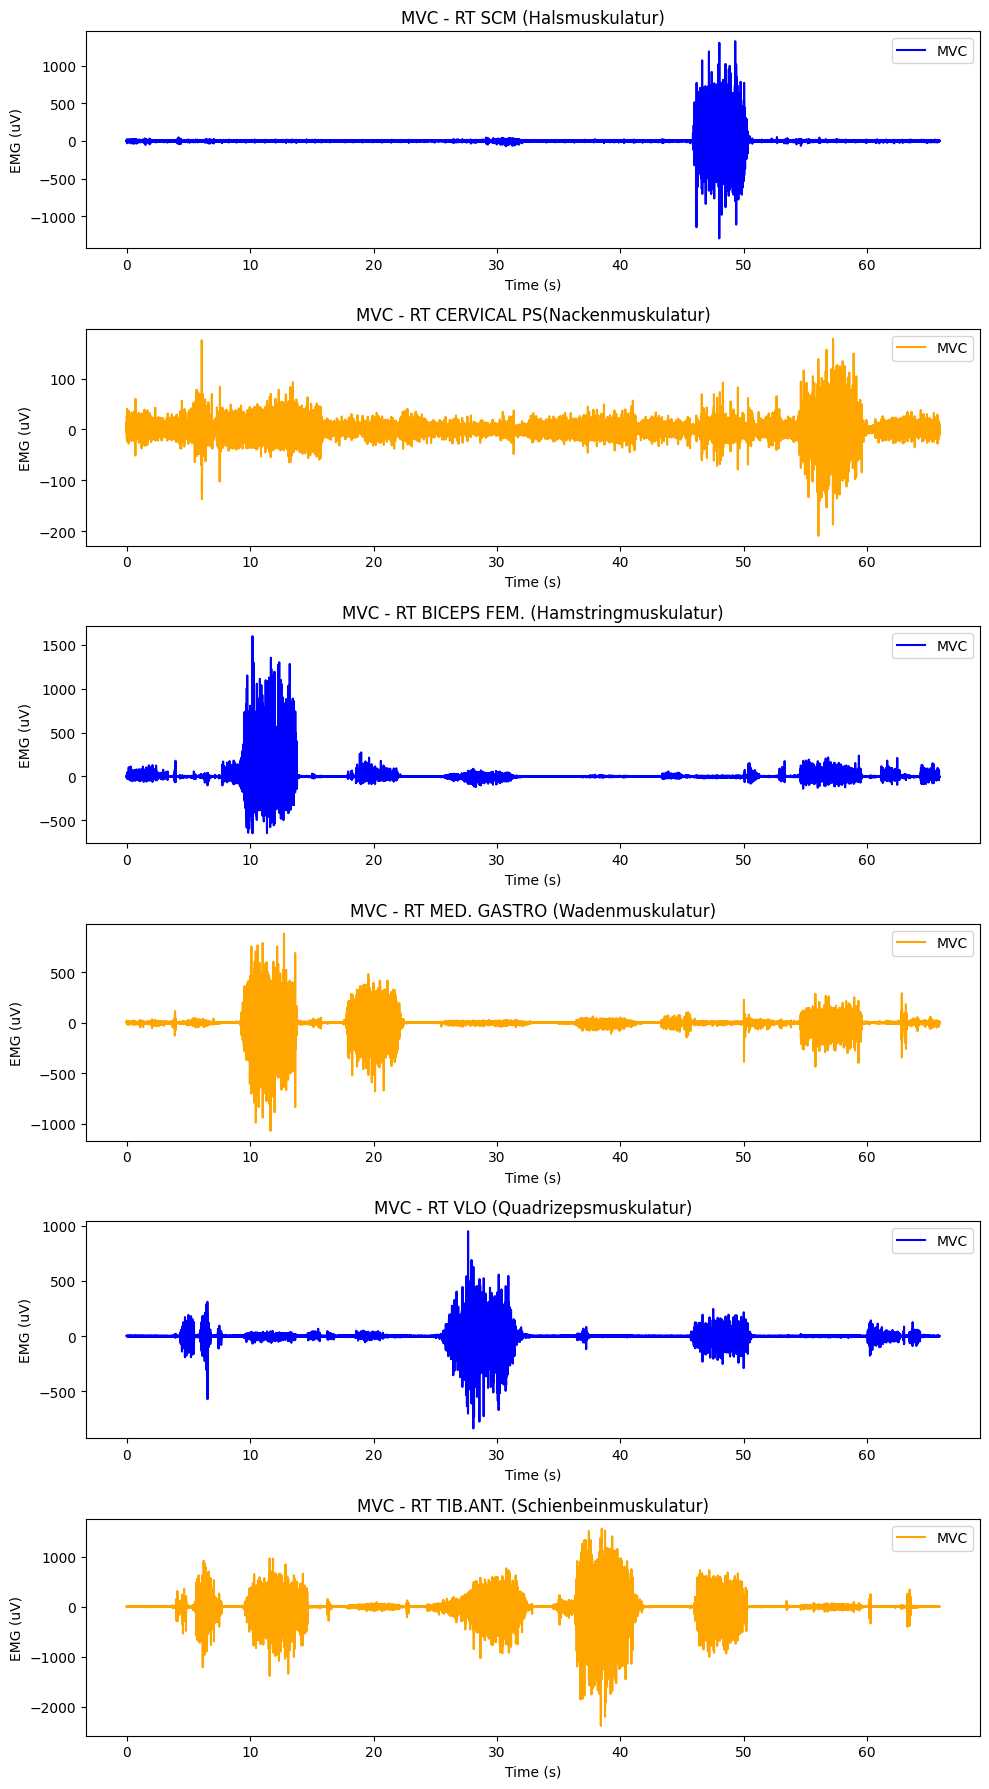

In [23]:
### Plotten der MVC Daten

plt.figure(figsize=(10, 18))
plt.subplot(6, 1, 1)
plt.plot(data_mvc['time'], data_mvc['RT SCM (uV)'], label='MVC', color='blue')
plt.title('MVC - RT SCM (Halsmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(data_mvc['time'], data_mvc['RT CERVICAL PS (uV)'], label='MVC', color='orange')
plt.title('MVC - RT CERVICAL PS(Nackenmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(data_mvc['time'], data_mvc['RT BICEPS FEM. (uV)'], label='MVC', color='blue')
plt.title('MVC - RT BICEPS FEM. (Hamstringmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(data_mvc['time'], data_mvc['RT MED. GASTRO (uV)'], label='MVC', color='orange')
plt.title('MVC - RT MED. GASTRO (Wadenmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(data_mvc['time'], data_mvc['RT VLO (uV)'], label='MVC', color='blue')
plt.title('MVC - RT VLO (Quadrizepsmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(data_mvc['time'], data_mvc['RT TIB.ANT. (uV)'], label='MVC', color='orange')
plt.title('MVC - RT TIB.ANT. (Schienbeinmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.tight_layout()
plt.show()

Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.


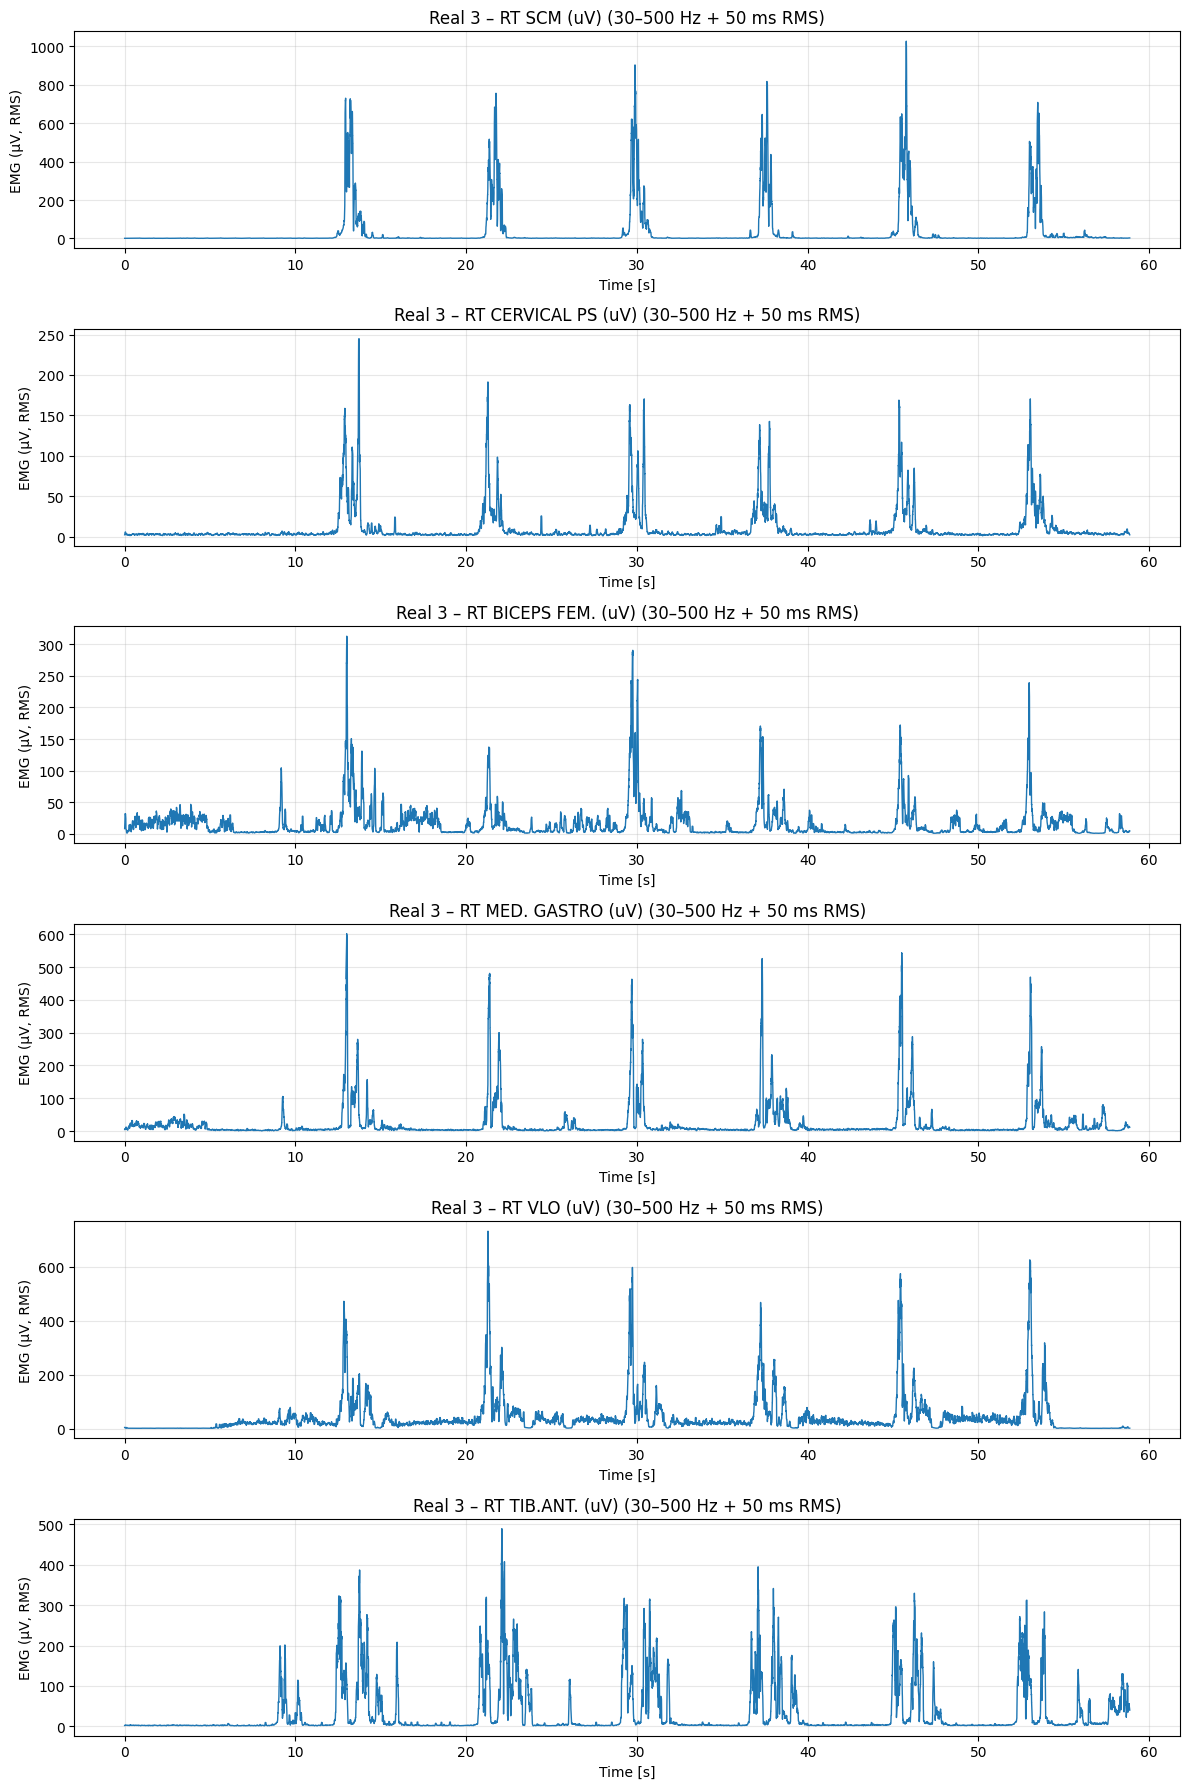

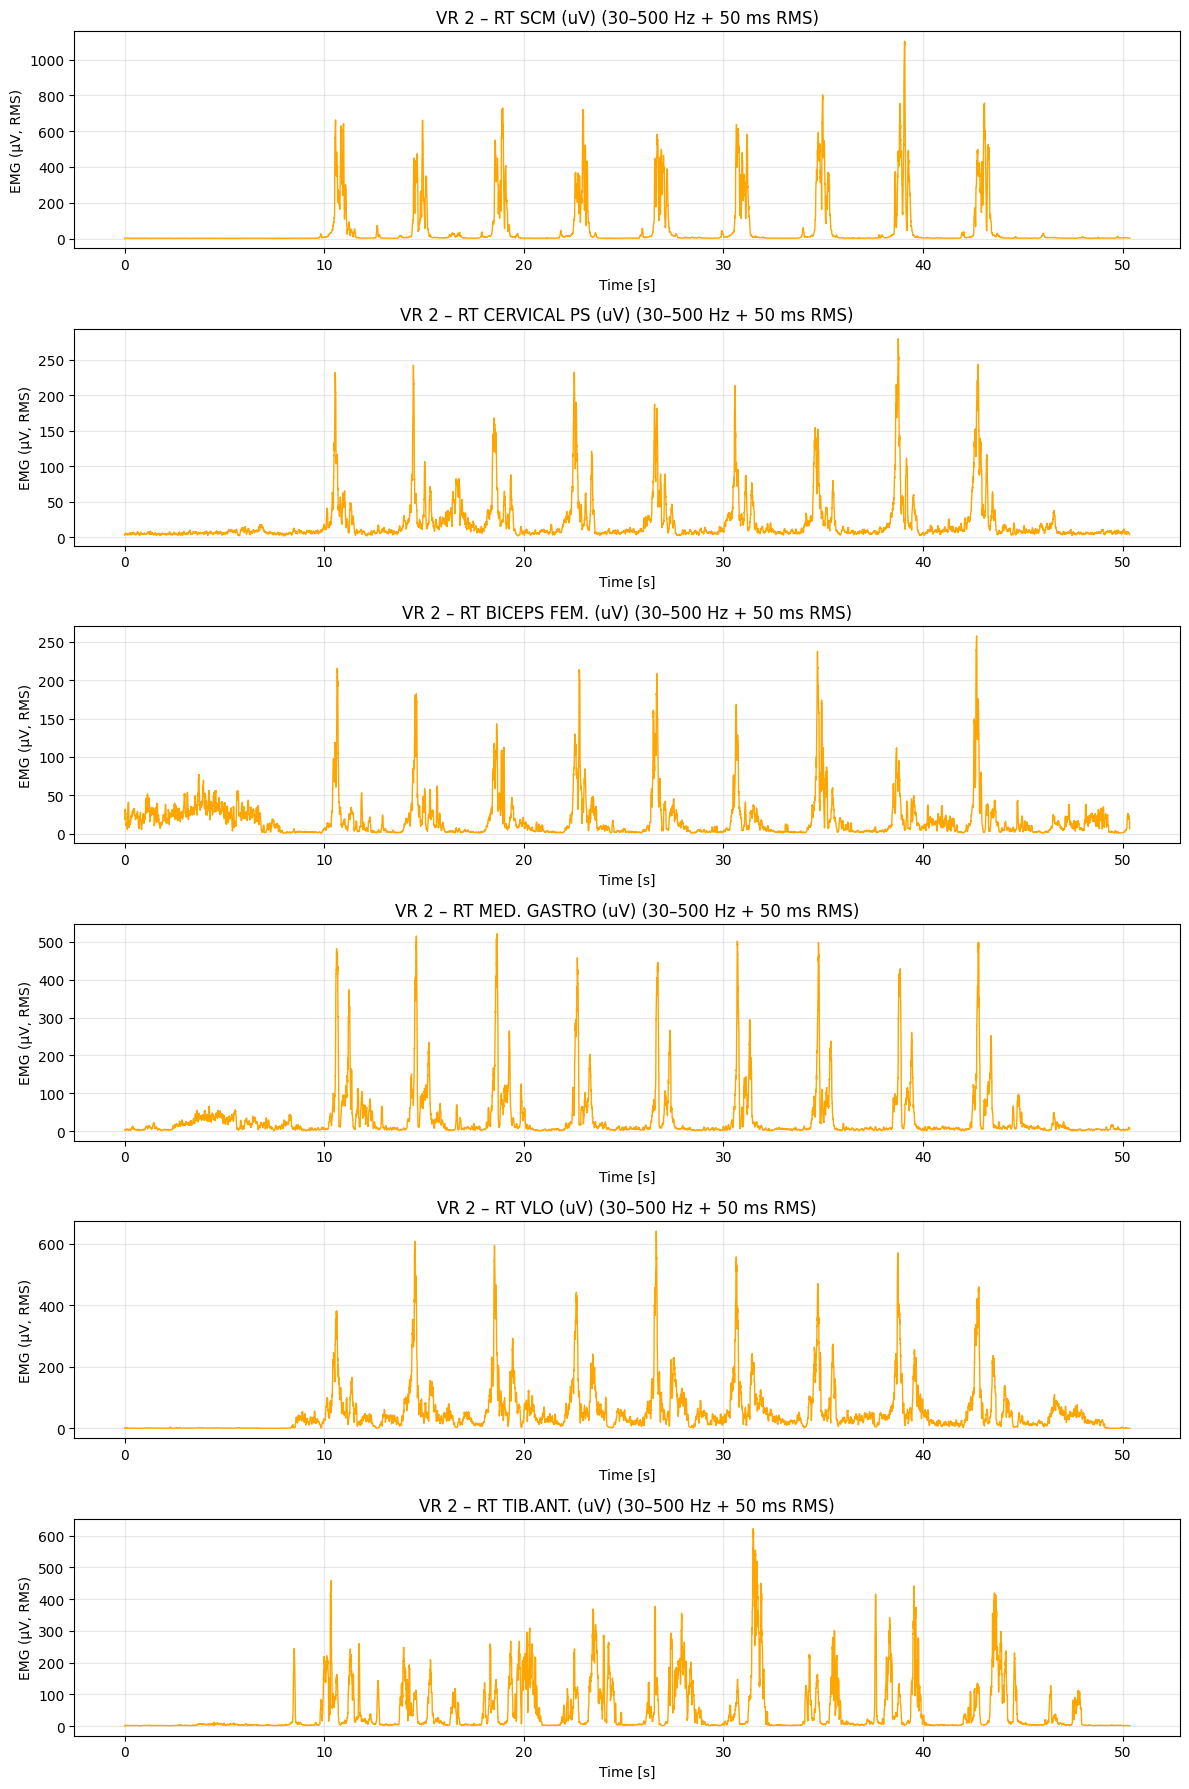

In [24]:
## Filtern und plotten der EMG Daten von Real 3 und VR 2

# ---- Filter-Funktionen ----

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def rms_smoothing(x, fs, window_ms=50):
    """
    RMS-Glättung über ein Fenster in Millisekunden.
    """
    window_samples = int(round(fs * window_ms / 1000.0))
    if window_samples < 1:
        window_samples = 1
    # RMS: sqrt( gleitender Mittelwert von x^2 )
    x_sq = x ** 2
    kernel = np.ones(window_samples) / window_samples
    mean_sq = np.convolve(x_sq, kernel, mode='same')
    return np.sqrt(mean_sq)

def preprocess_emg(df, emg_cols, fs):
    """
    Filtert EMG: Bandpass 30–500 Hz, 50 Hz Notch, RMS 50 ms.
    """
    out = df.copy()
    b_bp, a_bp = butter_bandpass(30, 500, fs)

    for muscle in emg_cols:
        raw = df[muscle].astype(float).values

        # 1) Bandpass 30–500 Hz
        bp = filtfilt(b_bp, a_bp, raw)

        # 2) 50 Hz Notch
        notch = apply_notch(bp, fs, f0=50)

        # 3) RMS 50 ms (inkl. Rektifikation)
        rms = rms_smoothing(notch, fs, window_ms=50)

        out[muscle + '_filtered'] = rms

    return out


# ---- Filtern ----

fs = 2000  # falls deine Samplingrate anders ist: hier ändern!

emg_cols = [
    'RT SCM (uV)',
    'RT CERVICAL PS (uV)',
    'RT BICEPS FEM. (uV)',
    'RT MED. GASTRO (uV)',
    'RT VLO (uV)',
    'RT TIB.ANT. (uV)'
]

real3_filtered = preprocess_emg(data_real3, emg_cols, fs)
vr2_filtered   = preprocess_emg(data_vr2, emg_cols, fs)

print("Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.")


# ---- Plot: Real3 gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(real3_filtered['time'], real3_filtered[muscle + '_filtered'], linewidth=1)
    plt.title(f"Real 3 – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ---- Plot: VR2 gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(vr2_filtered['time'], vr2_filtered[muscle + '_filtered'], linewidth=1, color="orange")
    plt.title(f"VR 2 – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

MVC-Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.


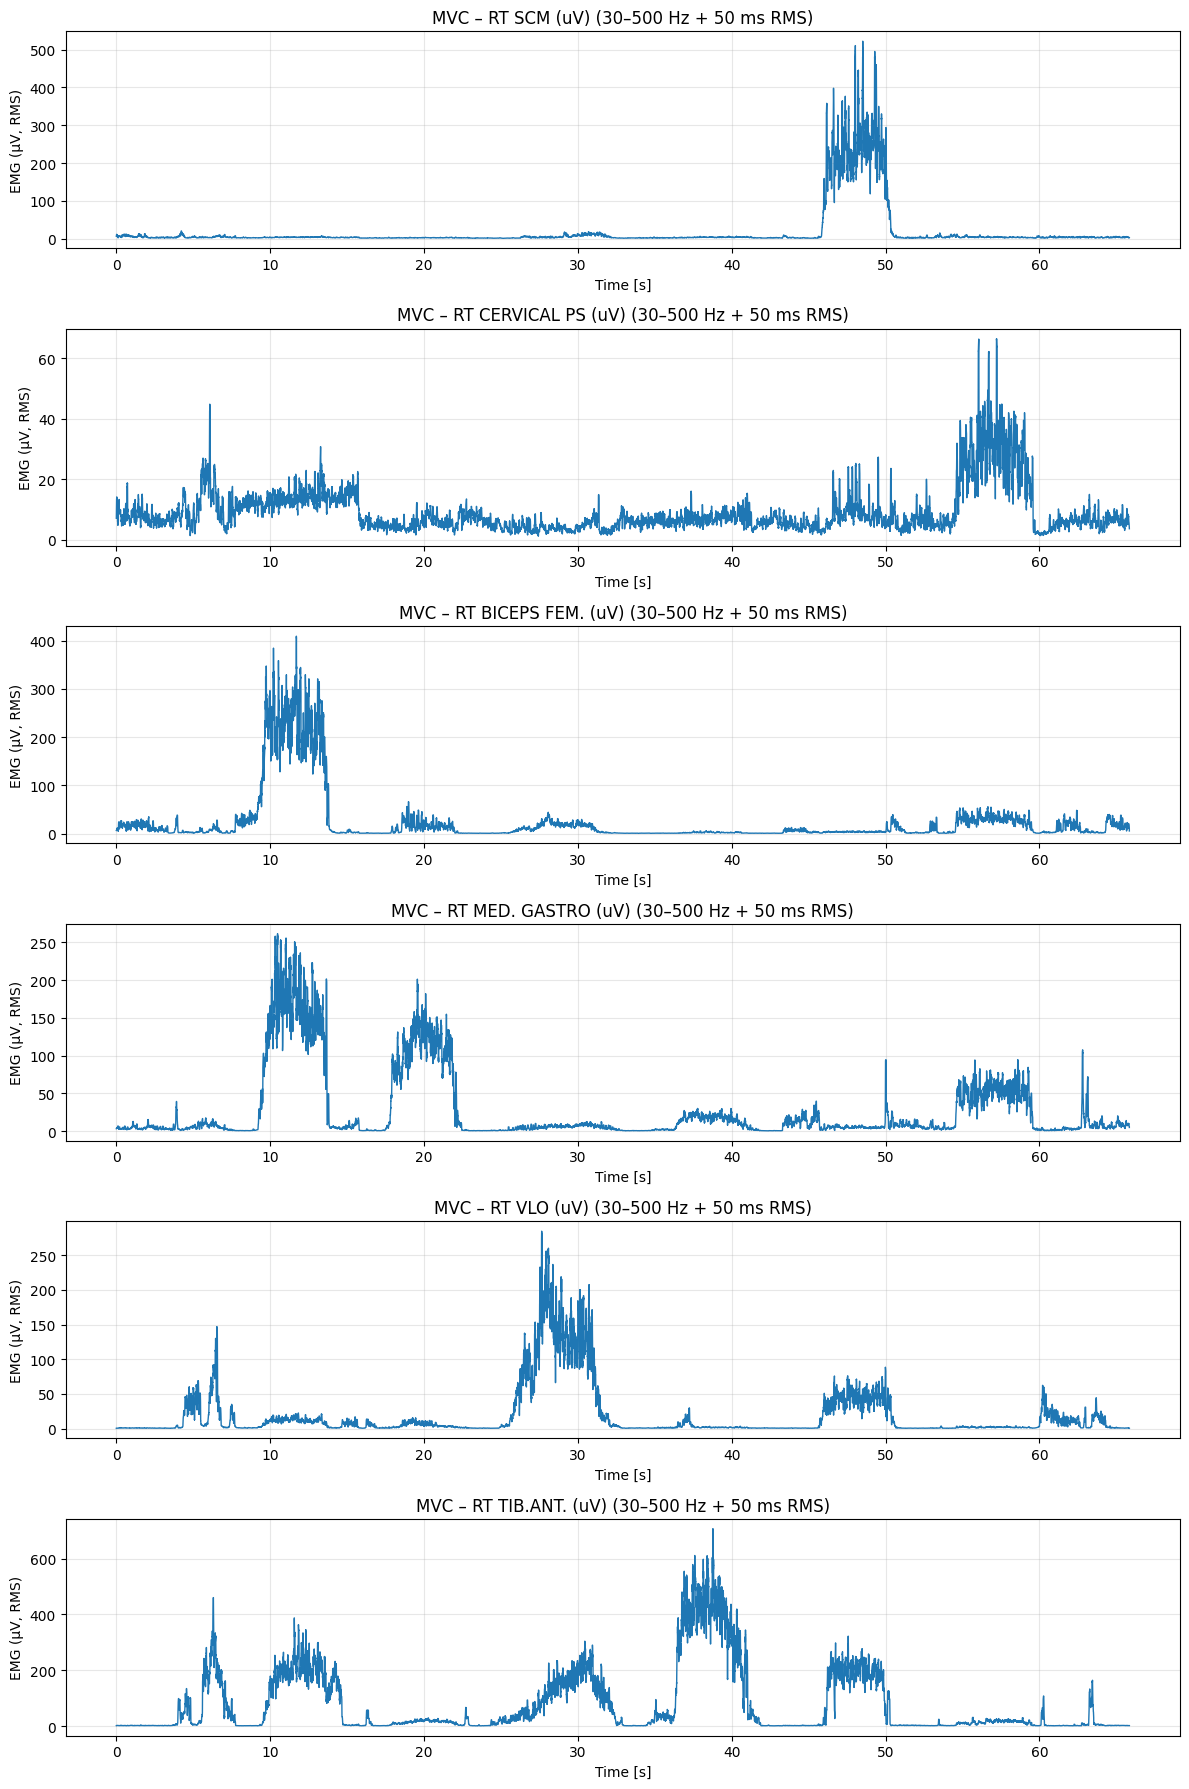

In [25]:
# MVC mit derselben Pipeline filtern: 30–500 Hz + 50 ms RMS

mvc_filtered = preprocess_emg(data_mvc, emg_cols, fs)

print("MVC-Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.")


# ---- Plot: MVC gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(mvc_filtered['time'], mvc_filtered[muscle + '_filtered'], linewidth=1)
    plt.title(f"MVC – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
## MVC Peaks berechnen und Normierung auf %MVC

# --- MVC-Peaks berechnen (aus gefiltertem MVC: 30–500 Hz + 50 ms RMS) ---

mvc_peaks = {}

for muscle in emg_cols:
    col_filt = muscle + '_filtered'
    if col_filt not in mvc_filtered.columns:
        print(f"Warnung: {col_filt} nicht in mvc_filtered gefunden – überspringe.")
        continue
    
    peak_val = mvc_filtered[col_filt].max(skipna=True)
    
    if np.isnan(peak_val) or peak_val <= 0:
        print(f"Warnung: Kein sinnvoller Peak für {muscle} gefunden – setze 1.0.")
        peak_val = 1.0
    
    mvc_peaks[muscle] = peak_val

print("MVC-Peaks (µV, RMS) pro Muskel:")
for m, v in mvc_peaks.items():
    print(f"{m}: {v:.2f} µV")


# --- Real3 & VR2 auf %MVC normieren ---

real3_norm = real3_filtered.copy()
vr2_norm   = vr2_filtered.copy()

for muscle in emg_cols:
    col_filt = muscle + '_filtered'
    if muscle not in mvc_peaks:
        continue
    
    mvc_val = mvc_peaks[muscle]
    
    if col_filt in real3_filtered.columns:
        real3_norm[muscle + '_%MVC'] = real3_filtered[col_filt] / mvc_val * 100.0
    if col_filt in vr2_filtered.columns:
        vr2_norm[muscle + '_%MVC']   = vr2_filtered[col_filt] / mvc_val * 100.0

print("\nNormierung abgeschlossen.")
print("Beispielspalten Real3:", [c for c in real3_norm.columns if '%MVC' in c])
print("Beispielspalten VR2:  ", [c for c in vr2_norm.columns if '%MVC' in c])

MVC-Peaks (µV, RMS) pro Muskel:
RT SCM (uV): 522.12 µV
RT CERVICAL PS (uV): 66.39 µV
RT BICEPS FEM. (uV): 409.04 µV
RT MED. GASTRO (uV): 261.39 µV
RT VLO (uV): 284.64 µV
RT TIB.ANT. (uV): 707.02 µV

Normierung abgeschlossen.
Beispielspalten Real3: ['RT SCM (uV)_%MVC', 'RT CERVICAL PS (uV)_%MVC', 'RT BICEPS FEM. (uV)_%MVC', 'RT MED. GASTRO (uV)_%MVC', 'RT VLO (uV)_%MVC', 'RT TIB.ANT. (uV)_%MVC']
Beispielspalten VR2:   ['RT SCM (uV)_%MVC', 'RT CERVICAL PS (uV)_%MVC', 'RT BICEPS FEM. (uV)_%MVC', 'RT MED. GASTRO (uV)_%MVC', 'RT VLO (uV)_%MVC', 'RT TIB.ANT. (uV)_%MVC']


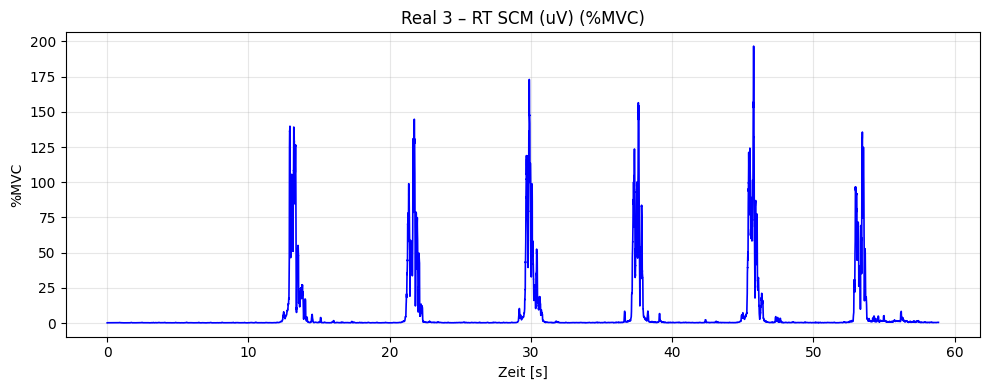

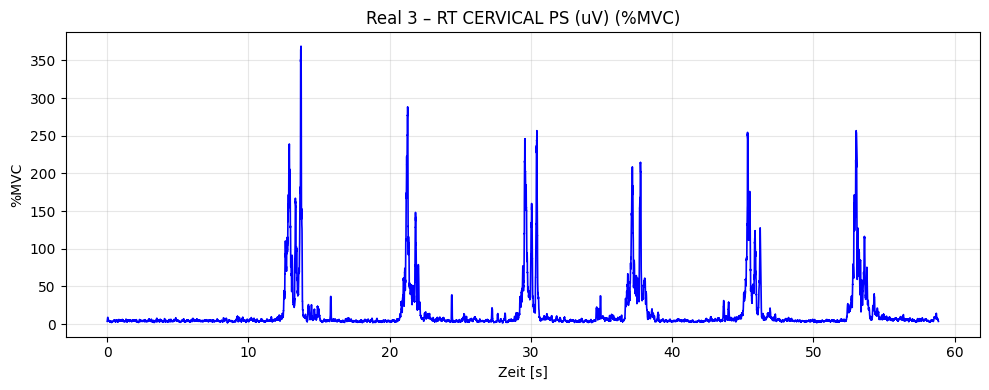

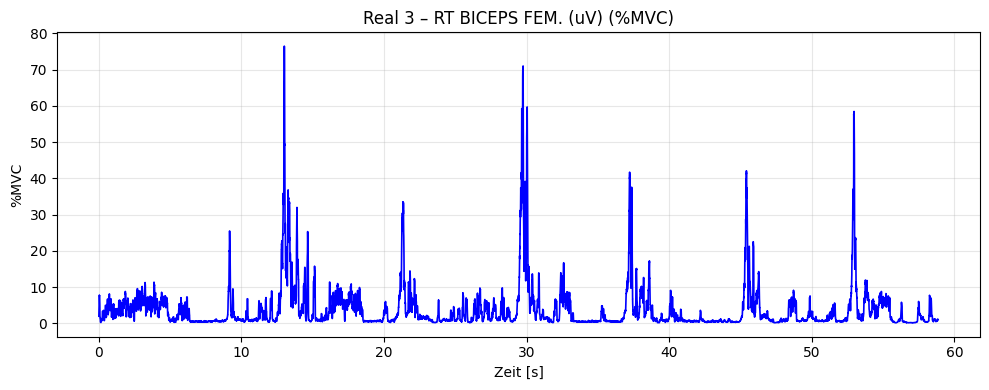

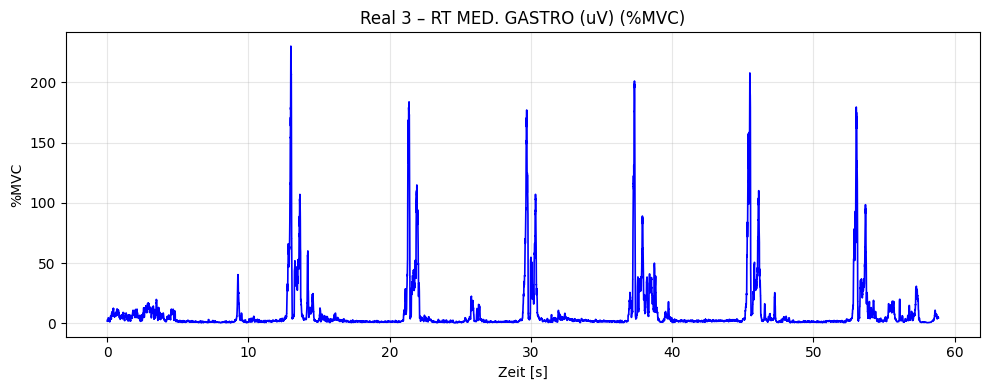

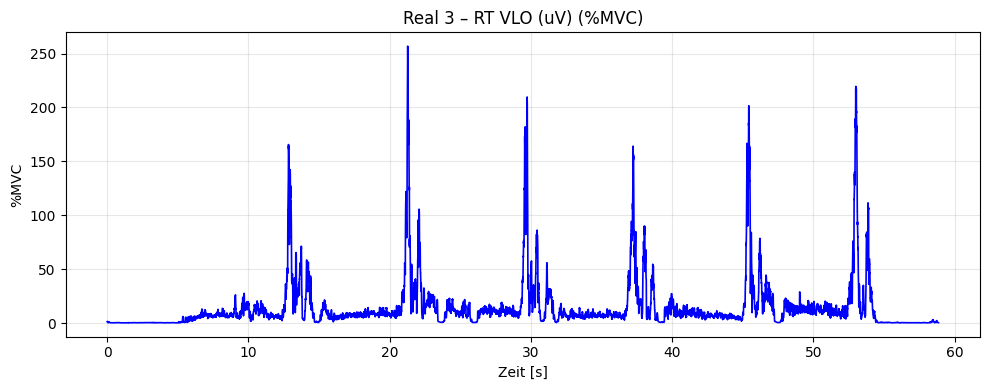

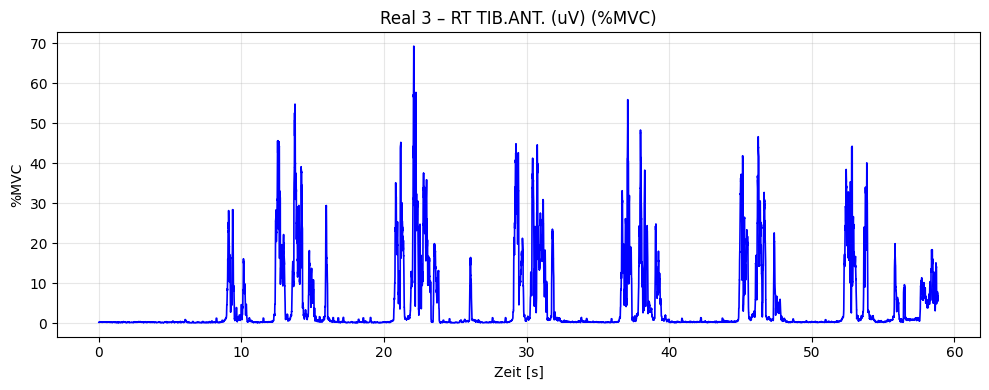

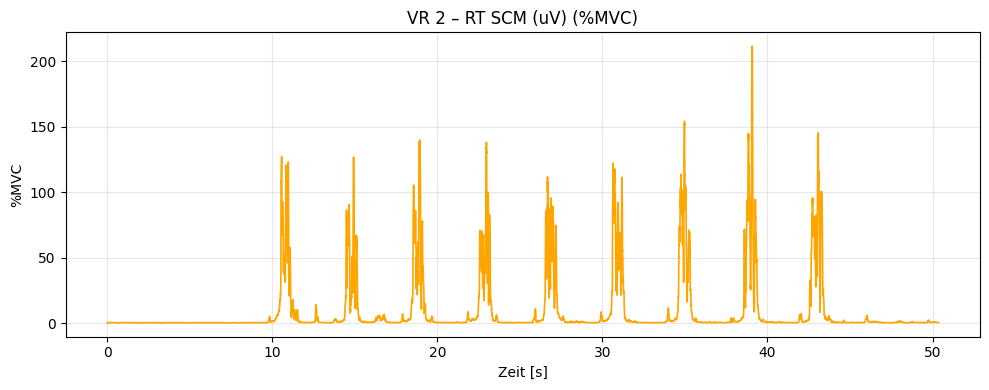

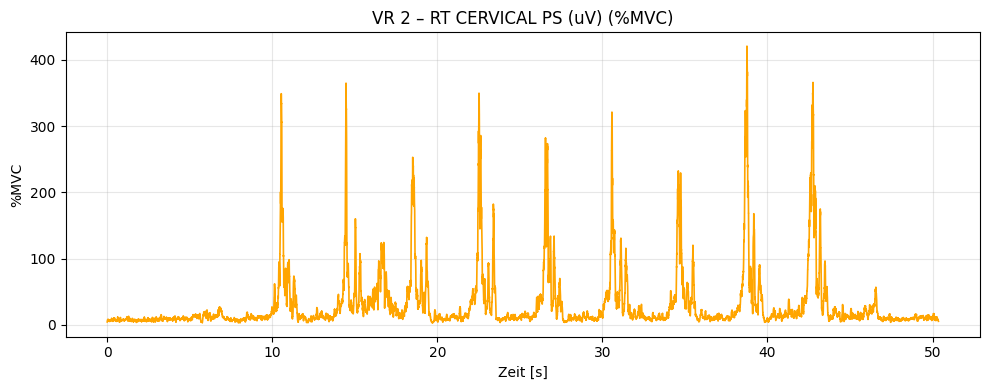

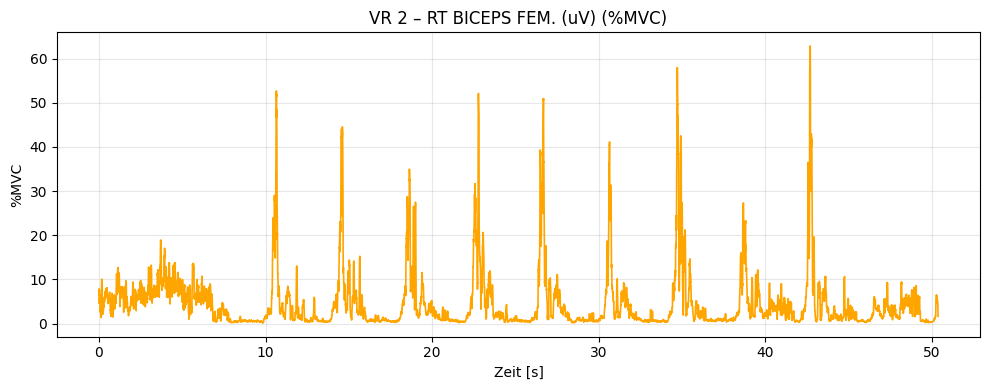

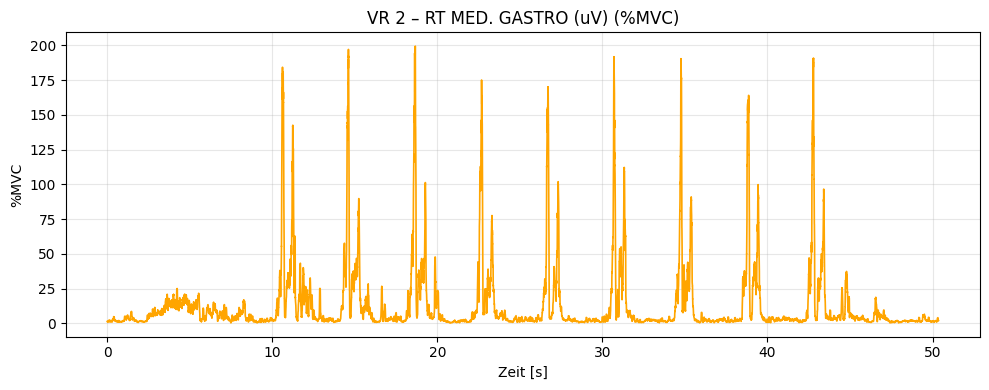

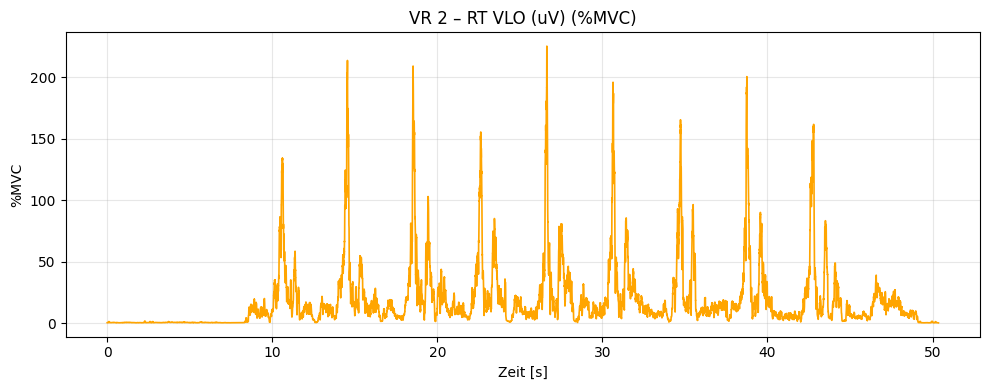

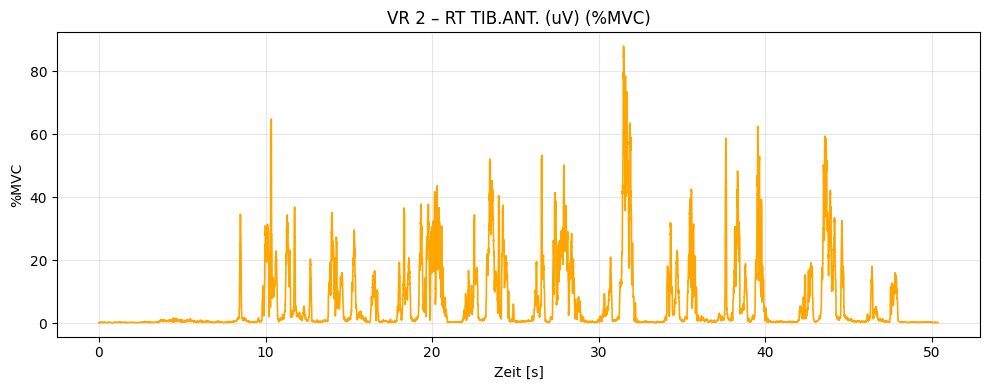

In [27]:
# Plots der normierten Daten (Real3)

for muscle in emg_cols:
    col_pct = muscle + "_%MVC"

    if col_pct not in real3_norm.columns:
        print(f"Spalte fehlt: {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(real3_norm["time"], real3_norm[col_pct], linewidth=1.2, color="blue")

    plt.title(f"Real 3 – {muscle} (%MVC)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plots der normierten Daten (VR2)

for muscle in emg_cols:
    col_pct = muscle + "_%MVC"

    if col_pct not in vr2_norm.columns:
        print(f"Spalte fehlt: {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(vr2_norm["time"], vr2_norm[col_pct], linewidth=1.2, color="orange")

    plt.title(f"VR 2 – {muscle} (%MVC)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Starkes Filtering (30–500 Hz + 50 Hz Notch + RMS 100 ms) abgeschlossen.

MVC-Peaks (stark gefiltert, µV RMS):
RT SCM (uV): 444.84 µV
RT CERVICAL PS (uV): 56.06 µV
RT BICEPS FEM. (uV): 359.89 µV
RT MED. GASTRO (uV): 236.99 µV
RT VLO (uV): 234.84 µV
RT TIB.ANT. (uV): 599.42 µV

Normierung (stark gefiltert) abgeschlossen.
Beispielspalten Real3 (strong): ['RT SCM (uV)_%MVC_strong', 'RT CERVICAL PS (uV)_%MVC_strong', 'RT BICEPS FEM. (uV)_%MVC_strong', 'RT MED. GASTRO (uV)_%MVC_strong', 'RT VLO (uV)_%MVC_strong', 'RT TIB.ANT. (uV)_%MVC_strong']
Beispielspalten VR2  (strong): ['RT SCM (uV)_%MVC_strong', 'RT CERVICAL PS (uV)_%MVC_strong', 'RT BICEPS FEM. (uV)_%MVC_strong', 'RT MED. GASTRO (uV)_%MVC_strong', 'RT VLO (uV)_%MVC_strong', 'RT TIB.ANT. (uV)_%MVC_strong']


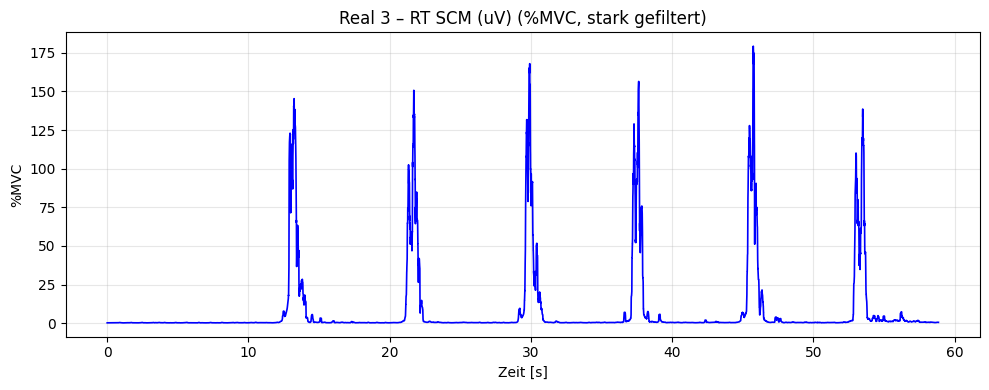

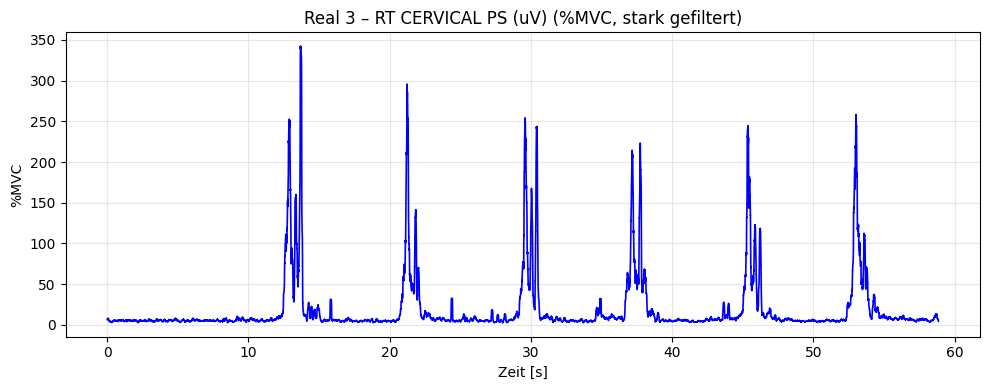

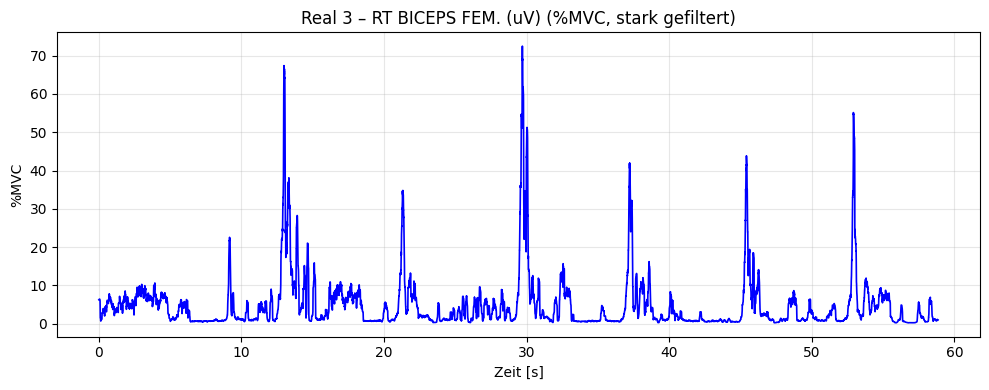

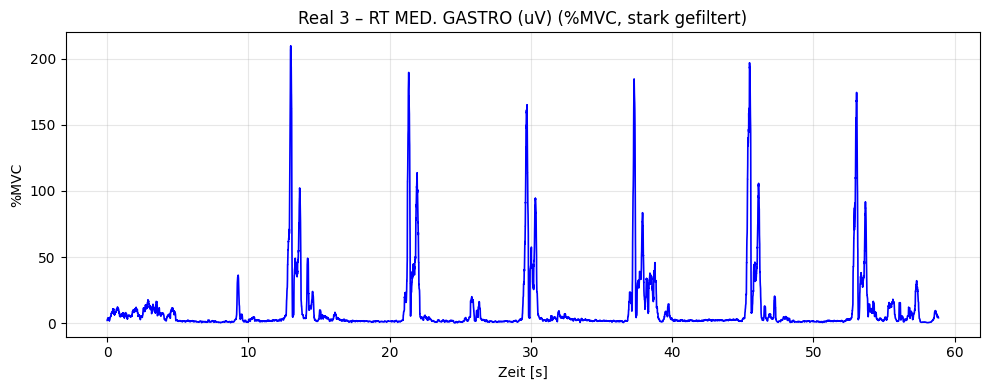

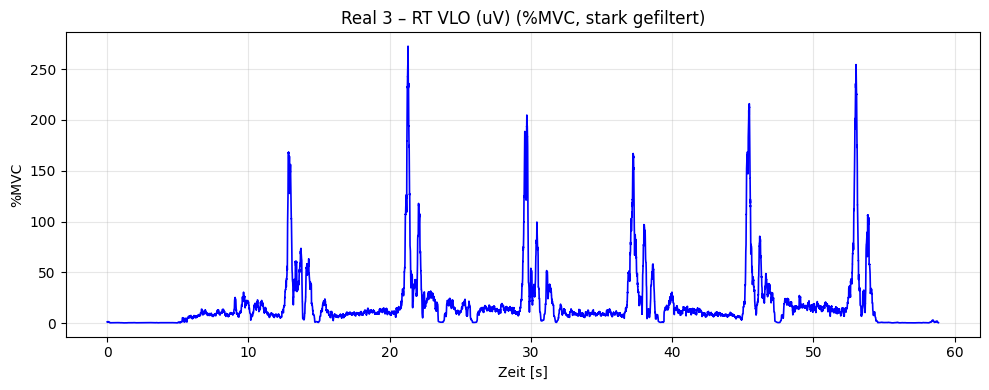

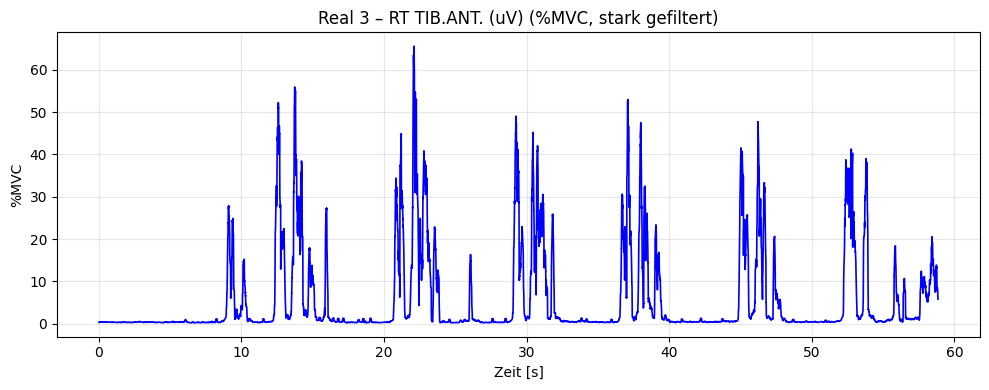

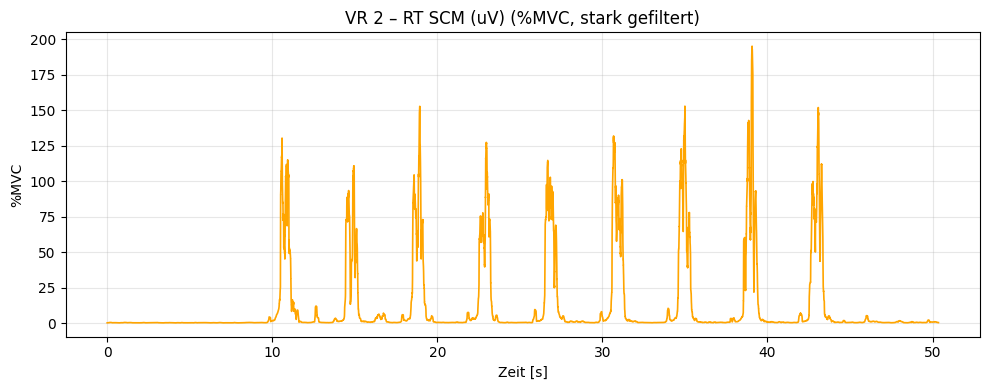

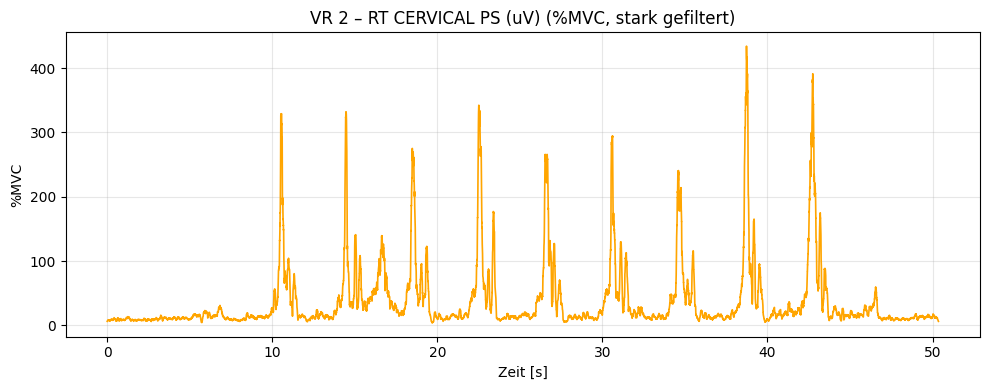

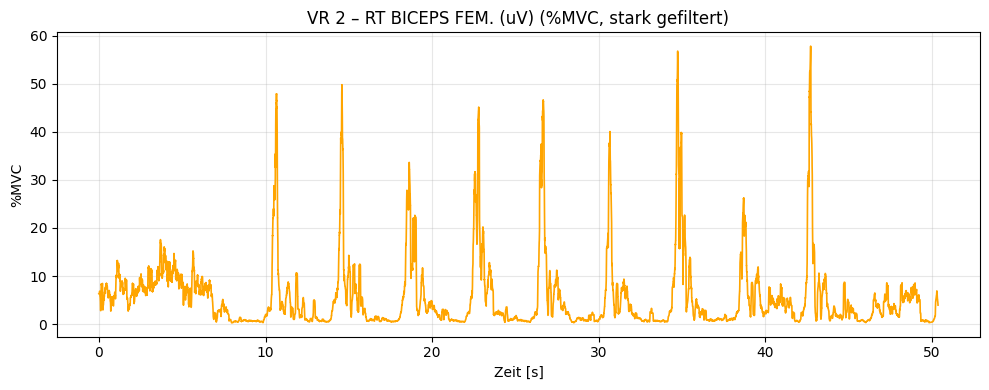

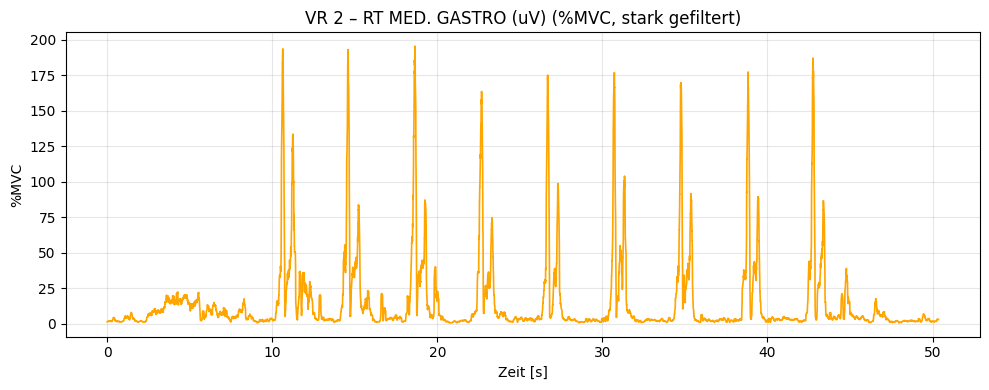

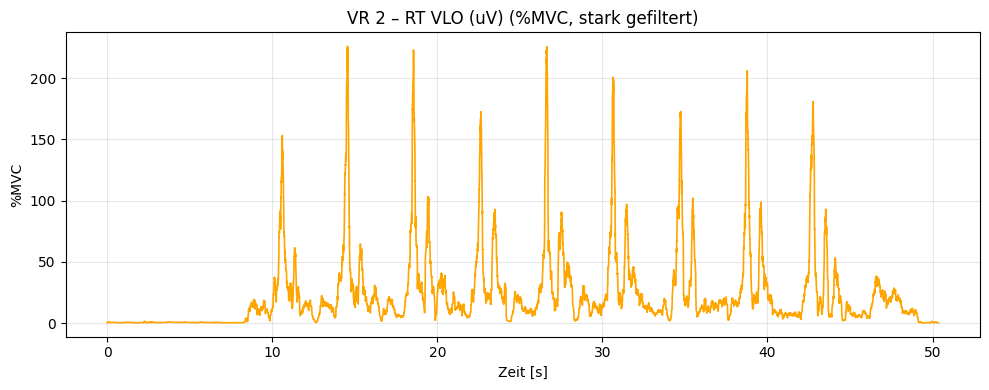

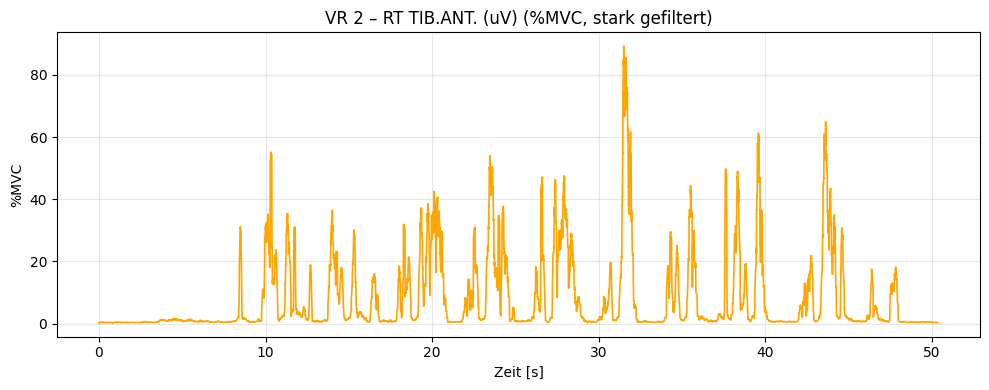

In [28]:
# ---------- Stärkeres Filtering: 30–500 Hz + 50 Hz Notch + RMS 100 ms ----------

def butter_bandpass_strong(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def rms_smoothing(x, fs, window_ms=100):
    """
    RMS-Glättung mit größerem Fenster (100 ms) -> deutlich glattere Kurven.
    """
    window_samples = int(round(fs * window_ms / 1000.0))
    if window_samples < 1:
        window_samples = 1
    x_sq = x ** 2
    kernel = np.ones(window_samples) / window_samples
    mean_sq = np.convolve(x_sq, kernel, mode='same')
    return np.sqrt(mean_sq)

def preprocess_emg_strong(df, emg_cols, fs):
    """
    Stärkere EMG-Filterung:
    - Bandpass 30–500 Hz
    - 50 Hz Notch
    - RMS 100 ms
    """
    out = df.copy()
    b_bp, a_bp = butter_bandpass_strong(30, 500, fs)

    for muscle in emg_cols:
        raw = df[muscle].astype(float).values

        # 1) Bandpass
        bp = filtfilt(b_bp, a_bp, raw)

        # 2) 50 Hz Notch
        notch = apply_notch(bp, fs, f0=50)

        # 3) RMS 100 ms
        rms = rms_smoothing(notch, fs, window_ms=100)

        out[muscle + '_filtered_strong'] = rms

    return out


# ---------- 1. Stärker filtern: Real3, VR2, MVC ----------

real3_filtered_strong = preprocess_emg_strong(data_real3, emg_cols, fs)
vr2_filtered_strong   = preprocess_emg_strong(data_vr2,   emg_cols, fs)
mvc_filtered_strong   = preprocess_emg_strong(data_mvc,   emg_cols, fs)

print("Starkes Filtering (30–500 Hz + 50 Hz Notch + RMS 100 ms) abgeschlossen.")


# ---------- 2. MVC-Peaks aus der stärker gefilterten MVC bestimmen ----------

mvc_peaks_strong = {}

for muscle in emg_cols:
    col_filt = muscle + "_filtered_strong"
    if col_filt not in mvc_filtered_strong.columns:
        print(f"Warnung: {col_filt} nicht in mvc_filtered_strong – überspringe.")
        continue

    peak_val = mvc_filtered_strong[col_filt].max(skipna=True)
    if np.isnan(peak_val) or peak_val <= 0:
        print(f"Warnung: Kein sinnvoller Peak für {muscle} (stark gefiltert) – setze 1.0.")
        peak_val = 1.0

    mvc_peaks_strong[muscle] = peak_val

print("\nMVC-Peaks (stark gefiltert, µV RMS):")
for m, v in mvc_peaks_strong.items():
    print(f"{m}: {v:.2f} µV")


# ---------- 3. Real3 & VR2 auf %MVC (stark gefiltert) normieren ----------

real3_norm_strong = real3_filtered_strong.copy()
vr2_norm_strong   = vr2_filtered_strong.copy()

for muscle in emg_cols:
    col_filt = muscle + "_filtered_strong"
    if muscle not in mvc_peaks_strong:
        continue

    mvc_val = mvc_peaks_strong[muscle]

    if col_filt in real3_filtered_strong.columns:
        real3_norm_strong[muscle + "_%MVC_strong"] = real3_filtered_strong[col_filt] / mvc_val * 100.0
    if col_filt in vr2_filtered_strong.columns:
        vr2_norm_strong[muscle + "_%MVC_strong"]   = vr2_filtered_strong[col_filt] / mvc_val * 100.0

print("\nNormierung (stark gefiltert) abgeschlossen.")
print("Beispielspalten Real3 (strong):", [c for c in real3_norm_strong.columns if '%MVC_strong' in c])
print("Beispielspalten VR2  (strong):", [c for c in vr2_norm_strong.columns if '%MVC_strong' in c])


# ---------- 4. Plots: jeder Muskel einzeln, stark gefilterte %MVC ----------

# Real3 – stark gefiltert, %MVC
for muscle in emg_cols:
    col_pct = muscle + "_%MVC_strong"
    if col_pct not in real3_norm_strong.columns:
        print(f"Spalte fehlt (Real3 strong): {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(real3_norm_strong["time"], real3_norm_strong[col_pct], linewidth=1.2, color="blue")
    plt.title(f"Real 3 – {muscle} (%MVC, stark gefiltert)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# VR2 – stark gefiltert, %MVC
for muscle in emg_cols:
    col_pct = muscle + "_%MVC_strong"
    if col_pct not in vr2_norm_strong.columns:
        print(f"Spalte fehlt (VR2 strong): {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(vr2_norm_strong["time"], vr2_norm_strong[col_pct], linewidth=1.2, color="orange")
    plt.title(f"VR 2 – {muscle} (%MVC, stark gefiltert)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [29]:
## Zyklen erkennen und Zeitnormalisierung auf 0–100 % Bewegungszyklus

# --------------------------
# Einstellungen
# --------------------------

time_col = "time"

trigger_muscle = "RT SCM (uV)"          # Trigger-Muskel
trigger_col = trigger_muscle + "_%MVC_strong"

threshold_pct = 20.0                    # Schwellwert in %MVC
pre_time_s = 1.5                        # Zyklus beginnt 1.5 s vor Überschreitung
min_spacing_s = 3.0                     # min. Abstand zwischen zwei Triggern
n_points = 101                          # 0–100 % in 1%-Schritten


# --------------------------
# Hilfsfunktionen
# --------------------------

def detect_cycles_starts(df, time_col, signal_col, threshold, 
                         pre_time_s=1.5, min_spacing_s=3.0, max_cycle_len=5.4):
    """
    Zyklusdefinition (mit max. Dauer 5.4 Sekunden):

    - Trigger: Signal überschreitet threshold (False -> True)
    - Zyklusstart: pre_time_s vor dem Trigger
    - Zyklusende:
        -> normal: Anfang des nächsten gültigen Zyklus
        -> zusätzlich begrenzt auf: t_cycle_start + max_cycle_len (5.4s)
    """

    t = df[time_col].to_numpy()
    y = df[signal_col].to_numpy()

    n = len(t)
    if n < 2:
        return []

    active = y > threshold

    # Rising edges: False → True
    rising_idx = np.where((~active[:-1]) & active[1:])[0] + 1

    # Falls am Anfang bereits aktiv
    if active[0]:
        rising_idx = np.r_[0, rising_idx]

    if len(rising_idx) == 0:
        return []

    rising_idx = np.sort(rising_idx)

    # Filter: mind. min_spacing_s Abstand zwischen zwei Events
    accepted = [rising_idx[0]]
    for idx in rising_idx[1:]:
        if t[idx] - t[accepted[-1]] >= min_spacing_s:
            accepted.append(idx)

    segments = []
    for k, start_idx in enumerate(accepted):

        # Zeit des Triggers
        t_trigger = t[start_idx]

        # Zyklusstart
        t_cycle_start = max(t[0], t_trigger - pre_time_s)

        # Normales Zyklusende: nächster Trigger
        if k < len(accepted) - 1:
            t_next_trigger = t[accepted[k + 1]]
        else:
            t_next_trigger = t[-1]

        # Maximales erlaubtes Ende
        t_max_end = t_cycle_start + max_cycle_len

        # Endzeit = das frühere von beiden
        t_cycle_end = min(t_next_trigger, t_max_end, t[-1])

        segments.append((t_cycle_start, t_cycle_end))

    return segments


def time_normalize_segment(df, time_col, signal_cols, t_start, t_end, n_points=101):
    """
    Schneidet df zwischen t_start und t_end und interpoliert
    alle signal_cols auf n_points → 0–100 % Bewegungszyklus.
    """
    mask = (df[time_col] >= t_start) & (df[time_col] <= t_end)
    seg = df.loc[mask].copy()

    if seg.shape[0] < 2:
        raise ValueError(f"Segment {t_start:.3f}–{t_end:.3f} hat zu wenige Punkte.")

    t_seg = seg[time_col].to_numpy()
    t_target = np.linspace(t_seg[0], t_seg[-1], n_points)
    cycle_pct = np.linspace(0, 100, n_points)

    out = pd.DataFrame({"cycle_pct": cycle_pct})
    for col in signal_cols:
        y = seg[col].to_numpy()
        y_interp = np.interp(t_target, t_seg, y)
        out[col] = y_interp

    return out


def build_cycles_for_condition(df_norm_strong, label):
    """
    - nutzt Trigger-Muskel RT SCM (uV)_%MVC_strong
    - findet Zyklen nach der definierten Logik
    - normalisiert alle *_%MVC_strong-Signale auf 0–100 %
    """
    print(f"\n=== Zyklus-Erkennung: {label} ===")

    if trigger_col not in df_norm_strong.columns:
        raise KeyError(f"{trigger_col} existiert nicht in {label}.")

    # 1) Zyklen per Trigger-Logik bestimmen
    segments = detect_cycles_starts(
        df_norm_strong,
        time_col=time_col,
        signal_col=trigger_col,
        threshold=threshold_pct,
        pre_time_s=pre_time_s,
        min_spacing_s=min_spacing_s
    )

    if not segments:
        print("  Keine Zyklen gefunden.")
        return [], []

    print("  Gefundene Zyklen:")
    for i, (ts, te) in enumerate(segments, 1):
        print(f"    Zyklus {i}: {ts:.3f}s -> {te:.3f}s (Dauer {te - ts:.3f}s)")

    # 2) alle %MVC_strong-Signale vorbereiten
    signal_cols = [m + "_%MVC_strong" for m in emg_cols
                   if m + "_%MVC_strong" in df_norm_strong.columns]

    # 3) Time-Normalisierung
    cycles = []
    for (ts, te) in segments:
        try:
            cyc = time_normalize_segment(
                df_norm_strong, time_col, signal_cols, ts, te, n_points=n_points
            )
            cycles.append(cyc)
        except ValueError as e:
            print(f"  Warnung: {e} – Zyklus übersprungen.")

    print(f"  Anzahl normalisierter Zyklen ({label}): {len(cycles)}")
    return cycles, segments


# def plot_cycles_individually(cycles, label, color):
#     """
#     Plottet jeden Zyklus einzeln, für jeden Muskel.
#     """
#     for i, cyc in enumerate(cycles, start=1):
#         for muscle in emg_cols:
#             col = muscle + "_%MVC_strong"
#             if col not in cyc.columns:
#                 continue

#             plt.figure(figsize=(8, 4))
#             plt.plot(cyc["cycle_pct"], cyc[col], linewidth=1.5, color=color)

#             plt.title(f"{label} – Zyklus {i} – {muscle} (%MVC, 0–100%)")
#             plt.xlabel("Bewegungszyklus [%]")
#             plt.ylabel("%MVC")
#             plt.grid(True, alpha=0.3)
#             plt.tight_layout()
#             plt.show()


# --------------------------
# Zyklen für Real 3 und VR 2 berechnen
# --------------------------

real3_cycles, real3_segments = build_cycles_for_condition(real3_norm_strong, "Real 3")
vr2_cycles,   vr2_segments   = build_cycles_for_condition(vr2_norm_strong,   "VR 2")

print(f"\n>>> Real 3 Zyklen: {len(real3_cycles)} gefunden")
print(f">>> VR 2 Zyklen:   {len(vr2_cycles)} gefunden")


# --------------------------
# Zyklen einzeln plotten
# --------------------------

# print("\n--- Einzelplots Real 3 (blau) ---")
# plot_cycles_individually(real3_cycles, "Real 3", color="blue")

# print("\n--- Einzelplots VR 2 (orange) ---")
# plot_cycles_individually(vr2_cycles, "VR 2", color="orange")


=== Zyklus-Erkennung: Real 3 ===
  Gefundene Zyklen:
    Zyklus 1: 11.345s -> 16.745s (Dauer 5.400s)
    Zyklus 2: 19.686s -> 25.087s (Dauer 5.400s)
    Zyklus 3: 28.066s -> 33.465s (Dauer 5.400s)
    Zyklus 4: 35.647s -> 41.047s (Dauer 5.400s)
    Zyklus 5: 43.795s -> 49.195s (Dauer 5.400s)
    Zyklus 6: 51.353s -> 56.753s (Dauer 5.400s)
  Anzahl normalisierter Zyklen (Real 3): 6

=== Zyklus-Erkennung: VR 2 ===
  Gefundene Zyklen:
    Zyklus 1: 8.962s -> 14.362s (Dauer 5.400s)
    Zyklus 2: 12.934s -> 18.334s (Dauer 5.400s)
    Zyklus 3: 16.971s -> 22.371s (Dauer 5.400s)
    Zyklus 4: 21.006s -> 26.406s (Dauer 5.400s)
    Zyklus 5: 25.006s -> 30.406s (Dauer 5.400s)
    Zyklus 6: 29.053s -> 34.453s (Dauer 5.400s)
    Zyklus 7: 33.087s -> 38.487s (Dauer 5.400s)
    Zyklus 8: 37.047s -> 42.447s (Dauer 5.400s)
    Zyklus 9: 41.034s -> 46.434s (Dauer 5.400s)
  Anzahl normalisierter Zyklen (VR 2): 9

>>> Real 3 Zyklen: 6 gefunden
>>> VR 2 Zyklen:   9 gefunden


In [30]:
### Zyklen zeiten abspeichern

def save_segments_to_csv(real_segments, vr_segments, filename="cycles_segments_summary.csv"):
    """
    Fasst die Listen der erkannten Zeitsegmente (Start- und Endzeiten)
    in einem DataFrame zusammen und speichert sie als CSV.
    """
    
    # DataFrame für Real 3 erstellen
    df_real = pd.DataFrame(real_segments, columns=["t_start_s", "t_end_s"])
    df_real["Label"] = "Real 3"
    df_real["Cycle_ID"] = np.arange(1, len(df_real) + 1)
    df_real["Duration_s"] = df_real["t_end_s"] - df_real["t_start_s"]
    
    # DataFrame für VR 2 erstellen
    df_vr = pd.DataFrame(vr_segments, columns=["t_start_s", "t_end_s"])
    df_vr["Label"] = "VR 2"
    df_vr["Cycle_ID"] = np.arange(1, len(df_vr) + 1)
    df_vr["Duration_s"] = df_vr["t_end_s"] - df_vr["t_start_s"]
    
    # Kombinieren und speichern
    df_combined = pd.concat([df_real, df_vr], ignore_index=True)
    
    df_combined.to_csv(filename, sep=";", index=False, float_format='%.3f')
    
    print(f"✅ Segment-Zusammenfassung erfolgreich gespeichert in: {filename}")
    print("\nÜbersicht der gespeicherten Daten:")
    print(df_combined)
    

# Funktion aufrufen (mit Ihren tatsächlichen Variablen)
save_segments_to_csv(real3_segments, vr2_segments)

✅ Segment-Zusammenfassung erfolgreich gespeichert in: cycles_segments_summary.csv

Übersicht der gespeicherten Daten:
    t_start_s  t_end_s   Label  Cycle_ID  Duration_s
0     11.3450  16.7450  Real 3         1         5.4
1     19.6865  25.0865  Real 3         2         5.4
2     28.0655  33.4655  Real 3         3         5.4
3     35.6470  41.0470  Real 3         4         5.4
4     43.7950  49.1950  Real 3         5         5.4
5     51.3530  56.7530  Real 3         6         5.4
6      8.9620  14.3620    VR 2         1         5.4
7     12.9345  18.3345    VR 2         2         5.4
8     16.9715  22.3715    VR 2         3         5.4
9     21.0055  26.4055    VR 2         4         5.4
10    25.0055  30.4055    VR 2         5         5.4
11    29.0530  34.4530    VR 2         6         5.4
12    33.0875  38.4875    VR 2         7         5.4
13    37.0470  42.4470    VR 2         8         5.4
14    41.0340  46.4340    VR 2         9         5.4


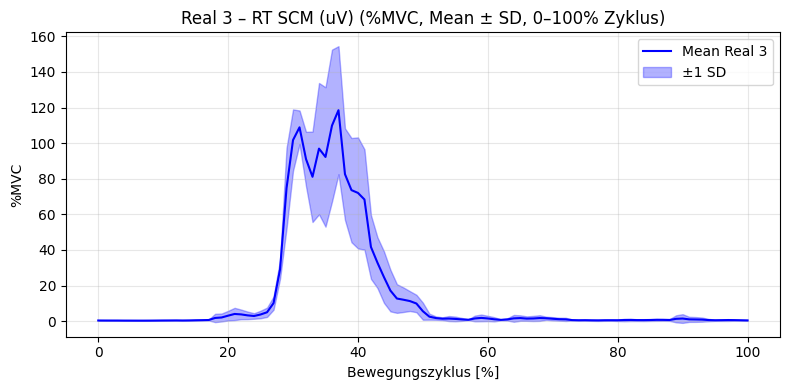

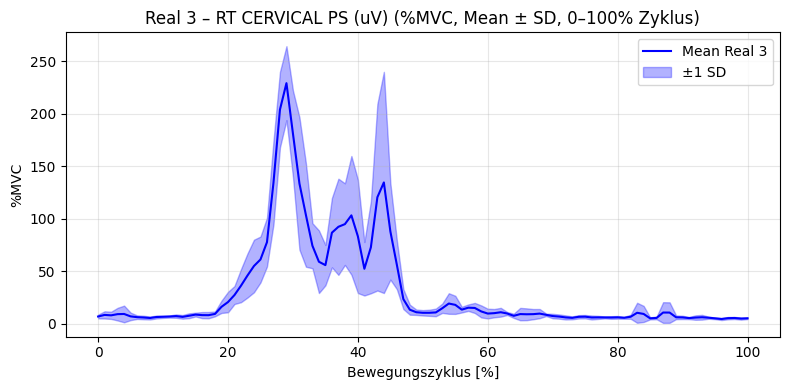

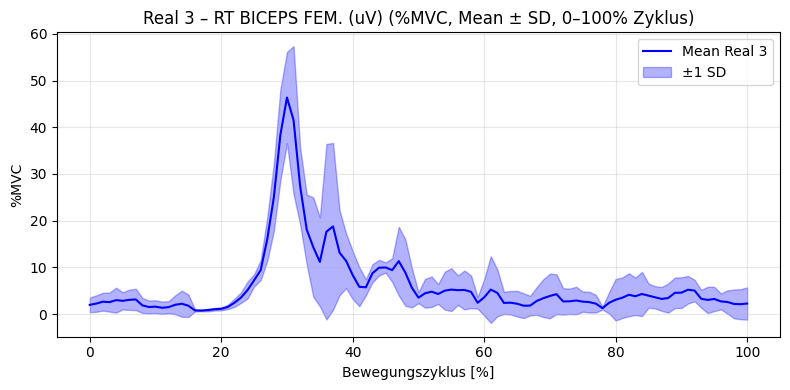

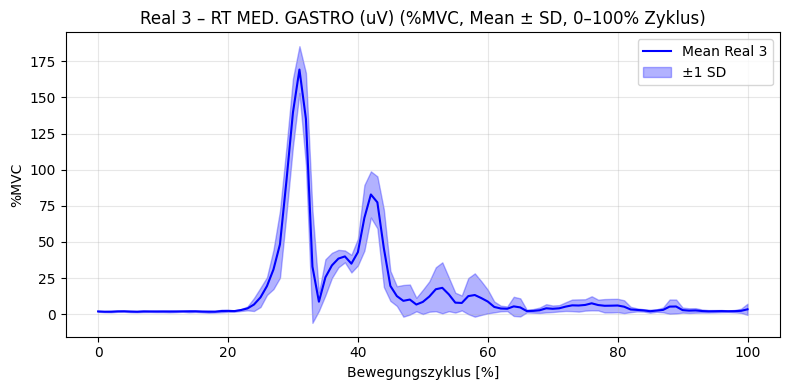

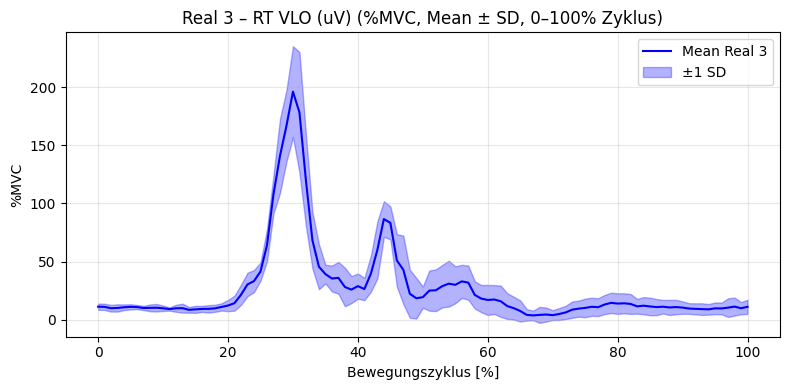

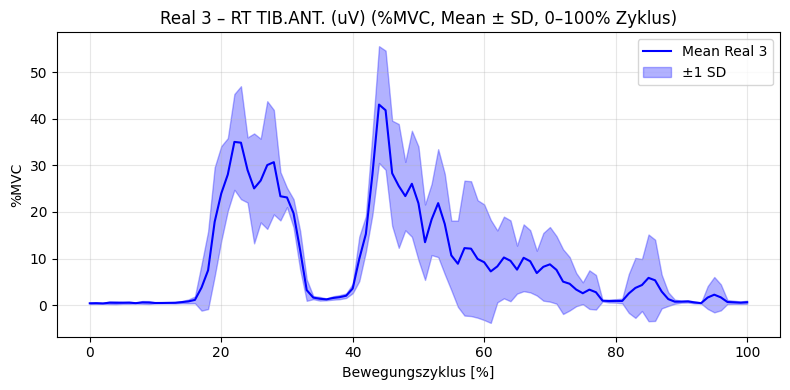

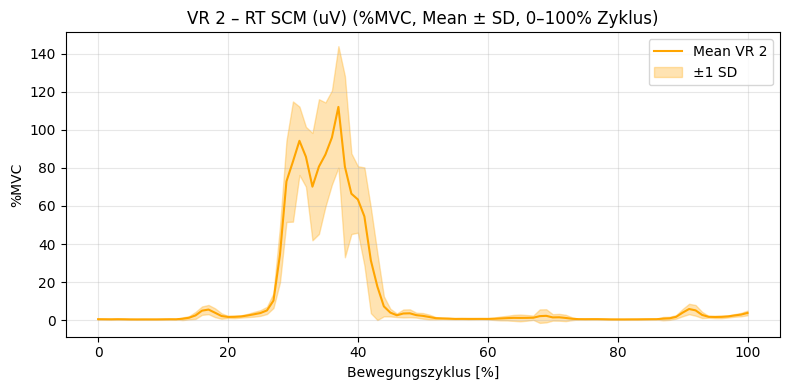

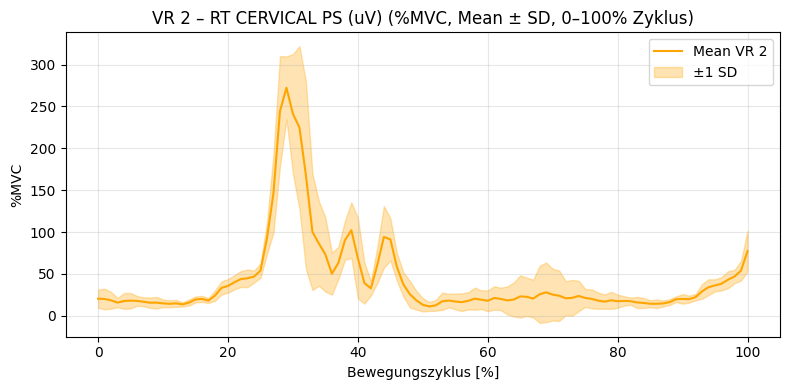

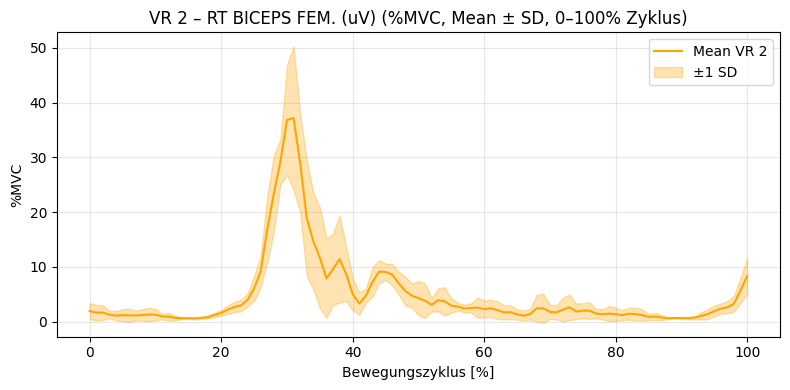

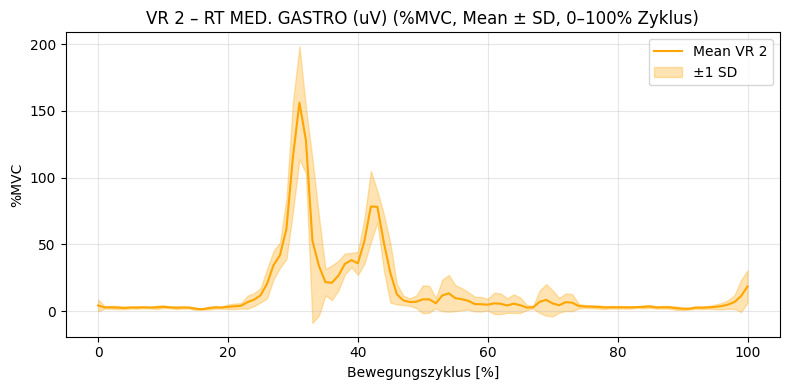

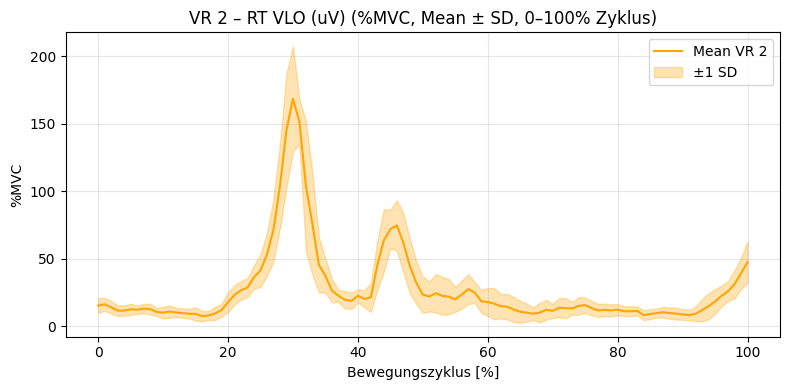

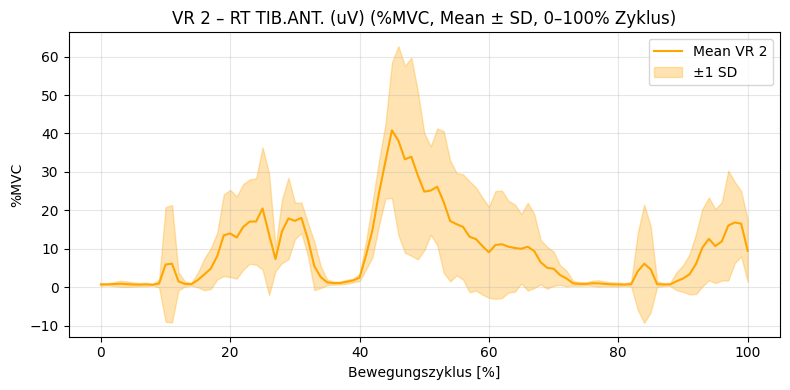

In [31]:
## Plotten von Mean ± SD über alle Zyklen

def compute_mean_sd_over_cycles(cycles, col_name):
    """
    cycles: Liste von DataFrames mit 'cycle_pct' und col_name
    col_name: z.B. 'RT SCM (uV)_%MVC_strong'

    Rückgabe: cycle_pct, mean, sd (jeweils numpy-Arrays)
    """
    if not cycles:
        return None, None, None

    # Alle Kurven dieses Muskels einsammeln
    curves = []
    for cyc in cycles:
        if col_name in cyc.columns:
            curves.append(cyc[col_name].to_numpy())

    if not curves:
        return None, None, None

    curves = np.vstack(curves)  # shape: (n_cycles, n_points)

    mean = np.mean(curves, axis=0)
    sd   = np.std(curves, axis=0)

    cycle_pct = cycles[0]["cycle_pct"].to_numpy()
    return cycle_pct, mean, sd


# ---------------------------
# Mean ± SD PLOTS – Real 3
# ---------------------------

if not real3_cycles:
    print("Keine Real3-Zyklen vorhanden – Mean±SD kann nicht berechnet werden.")
else:
    for muscle in emg_cols:
        col = muscle + "_%MVC_strong"

        cycle_pct, mean_real, sd_real = compute_mean_sd_over_cycles(real3_cycles, col)
        if cycle_pct is None:
            print(f"Real 3: keine gültigen Zyklen für {col} gefunden.")
            continue

        plt.figure(figsize=(8, 4))
        plt.plot(cycle_pct, mean_real, color="blue", label="Mean Real 3")
        plt.fill_between(cycle_pct, mean_real - sd_real, mean_real + sd_real,
                         color="blue", alpha=0.3, label="±1 SD")

        plt.title(f"Real 3 – {muscle} (%MVC, Mean ± SD, 0–100% Zyklus)")
        plt.xlabel("Bewegungszyklus [%]")
        plt.ylabel("%MVC")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


# ---------------------------
# Mean ± SD PLOTS – VR 2
# ---------------------------

if not vr2_cycles:
    print("Keine VR2-Zyklen vorhanden – Mean±SD kann nicht berechnet werden.")
else:
    for muscle in emg_cols:
        col = muscle + "_%MVC_strong"

        cycle_pct, mean_vr, sd_vr = compute_mean_sd_over_cycles(vr2_cycles, col)
        if cycle_pct is None:
            print(f"VR 2: keine gültigen Zyklen für {col} gefunden.")
            continue

        plt.figure(figsize=(8, 4))
        plt.plot(cycle_pct, mean_vr, color="orange", label="Mean VR 2")
        plt.fill_between(cycle_pct, mean_vr - sd_vr, mean_vr + sd_vr,
                         color="orange", alpha=0.3, label="±1 SD")

        plt.title(f"VR 2 – {muscle} (%MVC, Mean ± SD, 0–100% Zyklus)")
        plt.xlabel("Bewegungszyklus [%]")
        plt.ylabel("%MVC")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

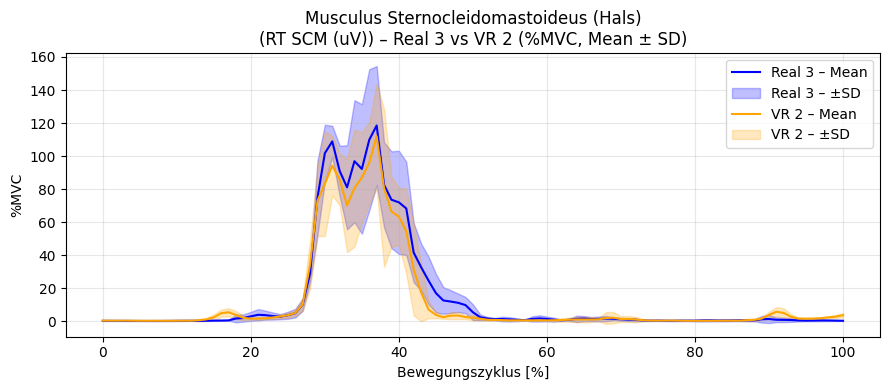

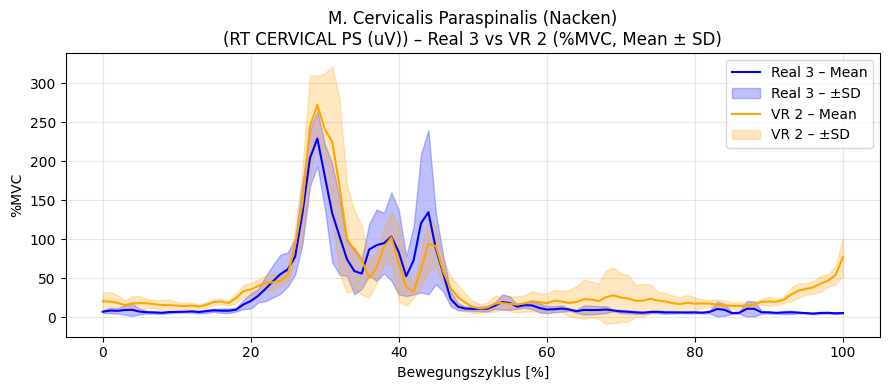

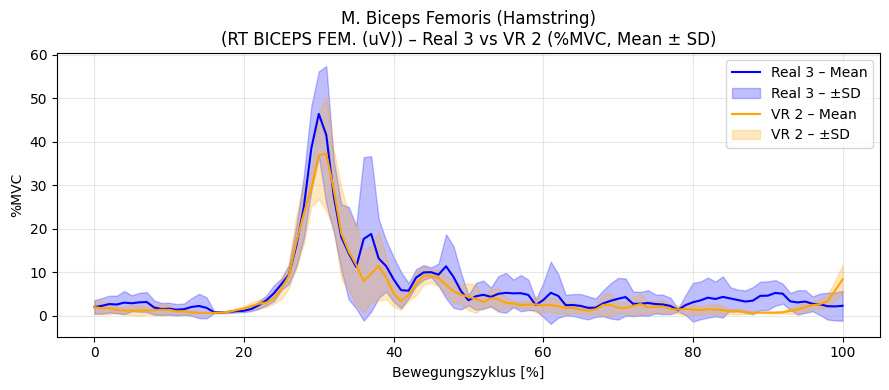

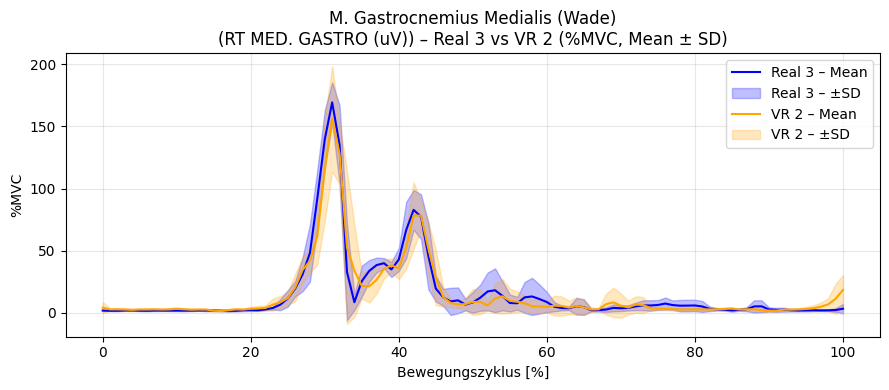

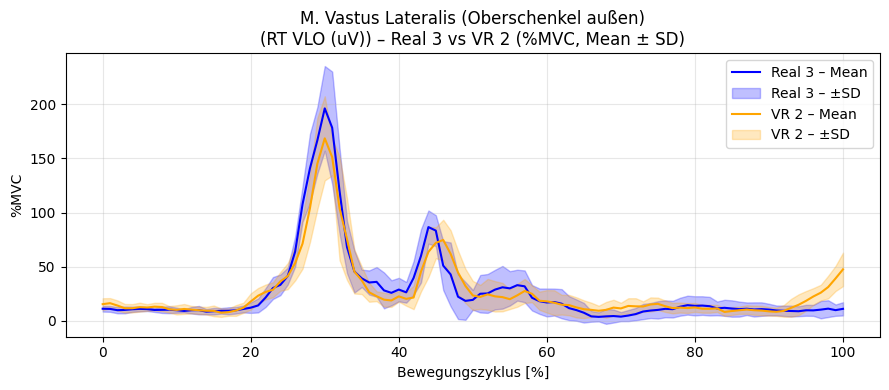

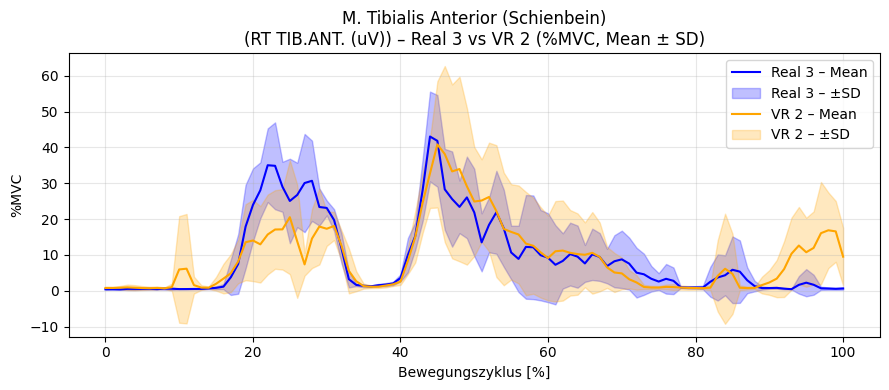

In [32]:
## Übereinander: Real3 vs VR2 – Mean ± SD

# Mapping der Muskelnamen zu deutschen Beschreibungen
muscle_name_map = {
    "RT SCM (uV)": "Musculus Sternocleidomastoideus (Hals)",
    "RT CERVICAL PS (uV)": "M. Cervicalis Paraspinalis (Nacken)",
    "RT BICEPS FEM. (uV)": "M. Biceps Femoris (Hamstring)",
    "RT MED. GASTRO (uV)": "M. Gastrocnemius Medialis (Wade)",
    "RT VLO (uV)": "M. Vastus Lateralis (Oberschenkel außen)",
    "RT TIB.ANT. (uV)": "M. Tibialis Anterior (Schienbein)"
}

for muscle in emg_cols:
    col = muscle + "_%MVC_strong"

    # 1) Mean ± SD für Real 3
    cycle_pct_real, mean_real, sd_real = compute_mean_sd_over_cycles(real3_cycles, col)

    # 2) Mean ± SD für VR 2
    cycle_pct_vr, mean_vr, sd_vr = compute_mean_sd_over_cycles(vr2_cycles, col)

    if cycle_pct_real is None or cycle_pct_vr is None:
        print(f"Skipping {muscle}: keine gültigen Zyklen in Real3 oder VR2.")
        continue

    # Deutsche Bezeichnung holen
    german_name = muscle_name_map.get(muscle, muscle)

    plt.figure(figsize=(9, 4))

    # Real 3 – blau
    plt.plot(cycle_pct_real, mean_real, color="blue", label="Real 3 – Mean")
    plt.fill_between(cycle_pct_real,
                     mean_real - sd_real,
                     mean_real + sd_real,
                     color="blue", alpha=0.25, label="Real 3 – ±SD")

    # VR 2 – orange
    plt.plot(cycle_pct_vr, mean_vr, color="orange", label="VR 2 – Mean")
    plt.fill_between(cycle_pct_vr,
                     mean_vr - sd_vr,
                     mean_vr + sd_vr,
                     color="orange", alpha=0.25, label="VR 2 – ±SD")

    # 📌 Deutscher + englischer Name im Titel
    plt.title(f"{german_name}\n({muscle}) – Real 3 vs VR 2 (%MVC, Mean ± SD)")

    plt.xlabel("Bewegungszyklus [%]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.show()